# Введение


Интернет-магазин «В один клик» столкнулся со снижением активности постоянных клиентов. Поскольку привлекать новых покупателей становится всё менее эффективно, компания приняла решение сфокусироваться на удержании текущей аудитории с помощью персонализированных предложений. Для этого потребуется определить, какие клиенты с высокой вероятностью начнут покупать меньше, и понять, какие факторы влияют на их поведение.

## Цель проекта
**Построить интерпретируемую модель машинного обучения для прогнозирования снижения покупательской активности клиентов в ближайшие 3 месяца** и на её основе выработать персонализированные рекомендации для маркетинга.


## В рамках проекта планируется:
- Построить модель машинного обучения, которая будет предсказывать снижение покупательской активности;
- Использовать группы признаков, описывающих взаимодействие клиента с платформой: коммуникации, поведение на сайте, продуктовые предпочтения и финансовую активность;
- Провести объединение и подготовку данных из нескольких таблиц;
- Выполнить исследовательский анализ данных (EDA) для выявления структур, выбросов и первичных закономерностей;
- Обучить и сравнить несколько моделей классификации: Logistic Regression, Decision Tree, KNeighborsClassifier и SVC;
- Использовать Optuna для автоматизированного подбора гиперпараметров моделей с помощью байесовской оптимизации (TPESampler);
- Оценить важность признаков с помощью методов:
  - Permutation Importance — для оценки вклада признаков в общее качество модели;
  - SHAP (SHapley Additive Explanations) — для объяснения вкладов признаков в конкретные предсказания.

Кроме того, планируется использовать методы отбора признаков (SelectKBest) для уменьшения размерности и повышения интерпретируемости модели. На заключительном этапе будут выделены ключевые сегменты клиентов, у которых активность может снизиться, и на основе этого сформулированы рекомендации для персонализированных маркетинговых действий.

Результатом станет система, позволяющая выявлять пользователей с высоким риском снижения активности и принимать обоснованные меры для их удержания.

---
Проект будет выполнен с использованием библиотек `pandas`, `scikit-learn`, `optuna`, `shap`, `matplotlib`, `seaborn` и других.

# Глава 1 - Загрузка данных

В начале проекта будут импортированы необходимые библиотеки для анализа данных, визуализации, построения моделей машинного обучения, оптимизации гиперпараметров и оценки важности признаков. Среди них: `pandas`, `numpy`, `scikit-learn`, `optuna`, `shap`, `seaborn`, `matplotlib` и другие.

На первом этапе проекта планируется загрузить и изучить четыре датасета, отражающих поведение покупателей на сайте, структуру их заказов, выручку и время, проведённое на платформе:

1. `market_file.csv` — основные признаки пользователей: тип сервиса, активность в акциях, категория интересов, действия на сайте и взаимодействие с маркетинговыми коммуникациями.  
2. `money.csv` — информация о среднемесячной прибыли, которую каждый покупатель приносит магазину.  
3. `market_time.csv` — данные о времени (в минутах), проведённом пользователем на сайте за предыдущие периоды.  
4. `market_money.csv` — выручка по каждому пользователю за последние три месяца.

Для удобства загрузки и первичной обработки будет создана универсальная функция `load_preprocess`, которая будет автоматически:
- Загружать CSV-файлы;
- Приводить названия столбцов к единому стилю;
- Отображать структуру таблицы, типы данных и примеры строк.

На этом этапе будет выполнена проверка:
- Размеров таблиц — ожидается по 1300 пользователей в каждой;
- Соответствия типов данных;
- Отсутствия пропусков — все значения должны быть готовы к анализу.

После завершения загрузки данных и базовой проверки можно будет перейти к их объединению, исследовательскому анализу и последующему построению моделей.

Импорты
-

In [1]:
!pip install phik optuna shap
!pip install -U scikit-learn

In [2]:
# ─── Системные библиотеки ───────────────────────────────
import os
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="resource_tracker")

# ─── Основные библиотеки для анализа данных ─────────────
import numpy as np
import pandas as pd

# ─── Визуализация ───────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display

# ─── Корреляционный анализ (Phik) ───────────────────────
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# ─── Обработка данных ───────────────────────────────────
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ─── Модели ──────────────────────────────────────────────
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# ─── Оценка моделей ─────────────────────────────────────
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    fbeta_score,
    precision_score,
    recall_score,
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
)

from sklearn.base import clone

from sklearn.inspection import permutation_importance

# ─── Отбор признаков и мультиколлинеарность ─────────────
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ─── Оптимизация (Optuna) ───────────────────────────────
import optuna
from optuna import distributions
from optuna.distributions import (
    CategoricalDistribution,
    FloatDistribution,
    IntDistribution,
)
from optuna.samplers import TPESampler
from optuna.trial import TrialState


# ─── Метрики расстояния ─────────────────────────────────
from scipy.spatial.distance import euclidean, cityblock, chebyshev

# ─── Интерпретация модели (SHAP) ────────────────────────
import shap

Для удобства создадим функцию для загрузки, обработки названия столбцов и вывода информации о таблице данных:

In [3]:
def load_preprocess(
    path: str,
    sep: str = ",",
    decimal: str = ".",
    lowercase_cols: bool = True,
    verbose: bool = True,
) -> pd.DataFrame:

    if not os.path.exists(path):
        if verbose:
            print(f"Файл не найден: {path}")
        return None
    ext = os.path.splitext(path)[1].lower()
    if ext in [".csv", ".txt"]:
        df = pd.read_csv(path, sep=sep, decimal=decimal)
    else:
        if verbose:
            print("Расширение файла не поддерживается")
        return None
    if lowercase_cols:
        df.columns = [col.lower().strip().replace(" ", "_") for col in df.columns]

    print("Размер таблицы:")
    print(f"Столбцов – {df.shape[1]}, строк – {df.shape[0]} \n")
    print("Типы данных:")
    df.info()

    print("\n Пример данных: \n")
    display(df.head(5))

    return df

In [4]:
# Таблица c данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
market_file = load_preprocess(
    "/datasets/market_file.csv"
)

Размер таблицы:
Столбцов – 13, строк – 1300 

Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Таблица с данными о 1300 пользователях. Типы данных впорядке.
Пропусков значений нет.

In [5]:
# Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
money = load_preprocess(
    "/datasets/money.csv", sep=";", decimal=","
)

Размер таблицы:
Столбцов – 2, строк – 1300 

Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB

 Пример данных: 



,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Таблица с данными о 1300 пользователях. Типы данных впорядке.
Пропусков значений нет.

In [6]:
# Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
market_time = load_preprocess(
    "/datasets/market_time.csv"
)

Размер таблицы:
Столбцов – 3, строк – 2600 

Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB

 Пример данных: 



,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Таблица с данными о 1300 пользователях за текущий и предыдущий месяцы. Типы данных впорядке. 
Пропусков значений нет.

In [7]:
# Таблица с данными о том, сколько покупатель потратил за год на маркетплейсе.
market_money = load_preprocess(
    "/datasets/market_money.csv"
)

Размер таблицы:
Столбцов – 3, строк – 3900 

Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB

 Пример данных: 



,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Таблица с данными о 1300 пользователях за последние 3 месяца. С типами данных все впорядке. 
Пропусков значений нет.

Вывод
-
Все четыре датасета успешно загружены и проверены: типы данных соответствуют ожиданиям, пропусков не обнаружено, количество пользователей стабильно — 1300 во всех таблицах. На основе подготовленных данных можно переходить к этапу объединения, исследовательского анализа и построения признаков для модели.


# Глава 2 -  Предобработка данных

На этом этапе проекта планируется провести исследовательский анализ данных и первичную предобработку для каждой таблицы. Будет выполнена проверка на наличие дубликатов и пропусков, приведены к единому формату строковые значения, устранены опечатки и расхождения в категориях. Также планируется оценить распределения числовых признаков и выявить возможные выбросы. 

Эти шаги необходимы для подготовки чистого и согласованного датасета, с которым в дальнейшем можно будет безопасно работать при объединении таблиц и построении моделей.

market_file
---

In [8]:
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


- Изучим общее количество дубликатов строк.
- Изучим уникальные значения в строковых столбцах. Исправим вид.
- Изучим статистику количественных значений входных признаков.

In [9]:
print(f"Количество дубликатов строк {market_file.duplicated().sum()}. \n")

for col in market_file.select_dtypes(exclude="number"):
    print(col)
    print(market_file[col].unique())
    print()

Количество дубликатов строк 0. 

покупательская_активность
['Снизилась' 'Прежний уровень']

тип_сервиса
['премиум' 'стандартт' 'стандарт']

разрешить_сообщать
['да' 'нет']

популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']



В столбце есть задвоение, которое связано с опечаткой. Исправим.
Приведем значения в столбцах к общему стандарту.

In [10]:
market_file["покупательская_активность"] = (
    market_file["покупательская_активность"]
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)
market_file["тип_сервиса"] = market_file["тип_сервиса"].replace("стандартт", "стандарт")
market_file["популярная_категория"] = (
    market_file["популярная_категория"].str.strip().str.lower().str.replace(" ", "_")
)

In [11]:
display(market_file.select_dtypes(include="number").describe().T[1:])

,count,mean,std,min,25%,50%,75%,max
маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.9,6.60
маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.0,5.00
длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.0,1079.00
акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.3,0.99
средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.0,6.00
неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.0,10.00
ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.0,9.00
страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.0,20.00


Значимых выбросов не видно.

money
---

Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.


- Изучим общее количество дубликатов строк.
- Изучим уникальные значения в строковых столбцах. Исправим вид.
- Изучим статистику количественных значений входных признаков.

In [12]:
print(f"Количество дубликатов строк {money.duplicated().sum()}. \n")

display(money.select_dtypes(include="number").describe().T[1:])

Количество дубликатов строк 0. 



,count,mean,std,min,25%,50%,75%,max
прибыль,1300.0,3.996631,1.013722,0.86,3.3,4.045,4.67,7.43


Значимых выбросов не видно.

market_time
---

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [13]:
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


- Изучим общее количество дубликатов строк.
- Изучим уникальные значения в строковых столбцах. Исправим вид.
- Изучим статистику количественных значений входных признаков.

In [14]:
print(f"Количество дубликатов строк {market_time.duplicated().sum()}. \n")

for col in market_time.select_dtypes(exclude="number"):
    print(col)
    print(market_time[col].unique())
    print()

Количество дубликатов строк 0. 

период
['текущий_месяц' 'предыдцщий_месяц']



Опечатка в значении 'предыдущий_месяц', которая может потом помешать в анализе. Исправим.

In [15]:
market_time["период"] = market_time["период"].replace(
    "предыдцщий_месяц", "предыдущий_месяц"
)

In [16]:
display(market_time.select_dtypes(include="number").describe().T[1:])

,count,mean,std,min,25%,50%,75%,max
минут,2600.0,13.336154,4.080198,4.0,10.0,13.0,16.0,23.0


Значимых выбросов не видно.

market_money
---

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.


- Изучим общее количество дубликатов строк.
- Изучим уникальные значения в строковых столбцах. Исправим вид.
- Изучим статистику количественных значений входных признаков.

In [17]:
print(f"Количество дубликатов строк {market_money.duplicated().sum()}. \n")

for col in market_money.select_dtypes(exclude="number"):
    print(col)
    print(market_money[col].unique())
    print()

Количество дубликатов строк 0. 

период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']



Проблем для исправления не наблюдается.

In [18]:
display(market_money.select_dtypes(include="number").describe().T[1:])

,count,mean,std,min,25%,50%,75%,max
выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.0,106862.2


Значимых выбросов не видно.

Вывод
-

В результате обработки:

- В таблице `market_file` были исправлены опечатки в категориальных признаках (`стандартт` заменено на `стандарт`) и приведены к нижнему регистру с подчёркиванием. Дубликаты и пропуски отсутствовали. Распределения признаков оказались в допустимых пределах.
- В таблице `money` данные оказались чистыми. Распределение прибыли нормальное, значимых выбросов не выявлено.
- В таблице `market_time` была обнаружена и устранена опечатка в значении `'предыдцщий_месяц'`, заменена на `'предыдущий_месяц'`. Пропусков и аномалий не зафиксировано.
- В таблице `market_money` все значения в порядке, категориальные признаки корректны, распределение выручки находится в рамках бизнес-логики.

Все таблицы успешно очищены и приведены к единому формату, что позволяет перейти к их объединению и формированию рабочей выборки.

# Глава 3 - Исследовательский анализ данных.

На этом этапе планируется провести подробный исследовательский анализ данных, включающий объединение таблиц, фильтрацию активных клиентов, изучение распределений признаков и анализ поведения пользователей. 

Мы сравним поведение клиентов с разным уровнем покупательской активности и выявим факторы, влияющие на её снижение. Будут построены гистограммы, боксплоты и графики взаимосвязей, чтобы обнаружить закономерности в данных, на которых позже можно будет строить модели прогнозирования.


market_file + money
---

Для исследования отберем клиентов с покупательской активностью не менее трех месяцев. Заметим, что в `money` показано, какую прибыль получает магазин от продаж каждому покупателю за последние 3 месяца. 

Смерджим два таблицы `market_file` и `money` с помощью внутреннего джоина. То есть в результирующй таблице окажутся только те клиенты, что есть в обеих таблицах.



In [19]:
# Оставим только те объекты, которые больше нуля
money_not_zero = money.query("прибыль > 0")

# Смерджим внутренним способом
file_merged = market_file.merge(money_not_zero, how="inner", on="id")

Исследуем статистику количественных признаков.

In [20]:
display(file_merged.select_dtypes(include="number").describe().T[1:])

,count,mean,std,min,25%,50%,75%,max
маркет_актив_6_мес,1300.0,4.253769,1.014814,0.90,3.70,4.200,4.90,6.60
маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.00,4.00,4.000,4.00,5.00
длительность,1300.0,601.898462,249.856289,110.00,405.50,606.000,806.00,1079.00
акционные_покупки,1300.0,0.319808,0.249843,0.00,0.17,0.240,0.30,0.99
средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.00,2.00,3.000,4.00,6.00
неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.00,1.00,3.000,4.00,10.00
ошибка_сервиса,1300.0,4.185385,1.955298,0.00,3.00,4.000,6.00,9.00
страниц_за_визит,1300.0,8.176923,3.978126,1.00,5.00,8.000,11.00,20.00
прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


Оказалось, что все клиенты в файле `market_file` совершали покупки последние 3 месяца.

- Данные, в целом, распределены сбалансировано. 
- Можно отметить, что значения столбца акционных покупок смещены вниз. Это заметно из того, что медиана ниже среднего значения.

In [21]:
file_merged.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,прибыль
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5,0.98
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4.16
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,3.13
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,4.87
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,4.21


Дискретные признаки:

`'маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц'`.

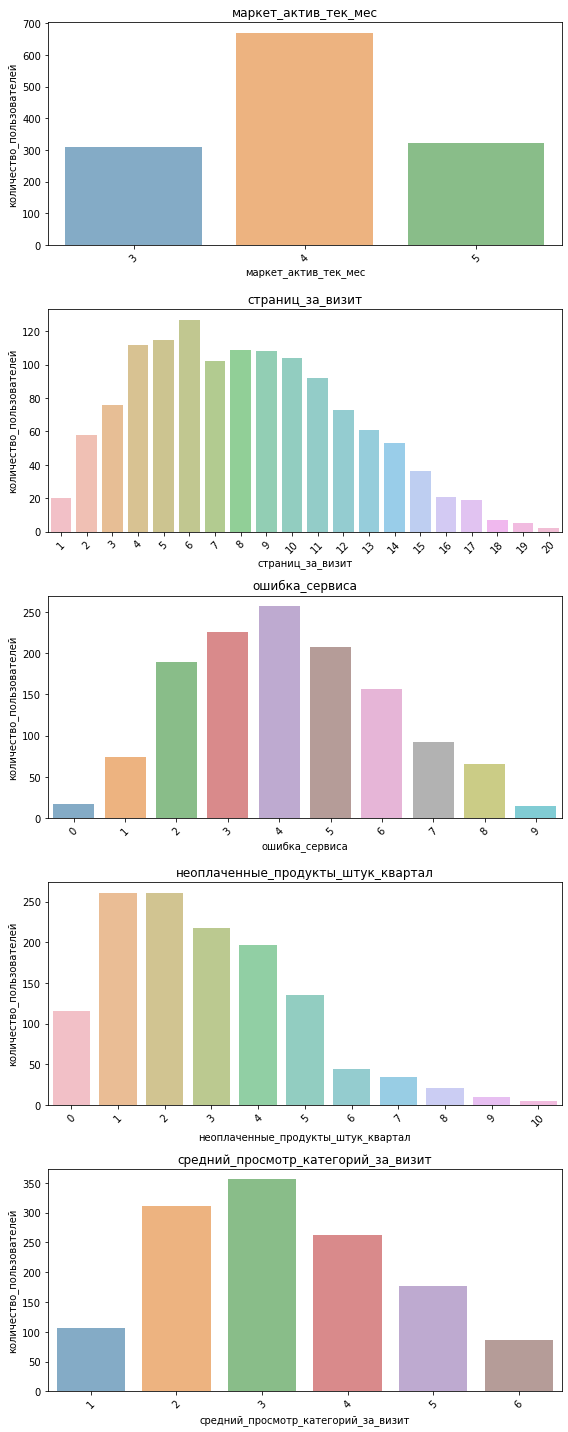

In [22]:
descrete_cols = ['маркет_актив_тек_мес','страниц_за_визит', 'ошибка_сервиса', 'неоплаченные_продукты_штук_квартал', 'средний_просмотр_категорий_за_визит']


fig, axs = plt.subplots(5, 1, figsize=(8, 20))
axs = axs.flatten()

for i in range(len(descrete_cols)):
    sns.countplot(
        x=descrete_cols[i],
        data=file_merged,
        ax=axs[i],
        alpha=0.6
    )
    axs[i].set_title(descrete_cols[i])
    axs[i].set_ylabel("количество_пользователей")
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



2


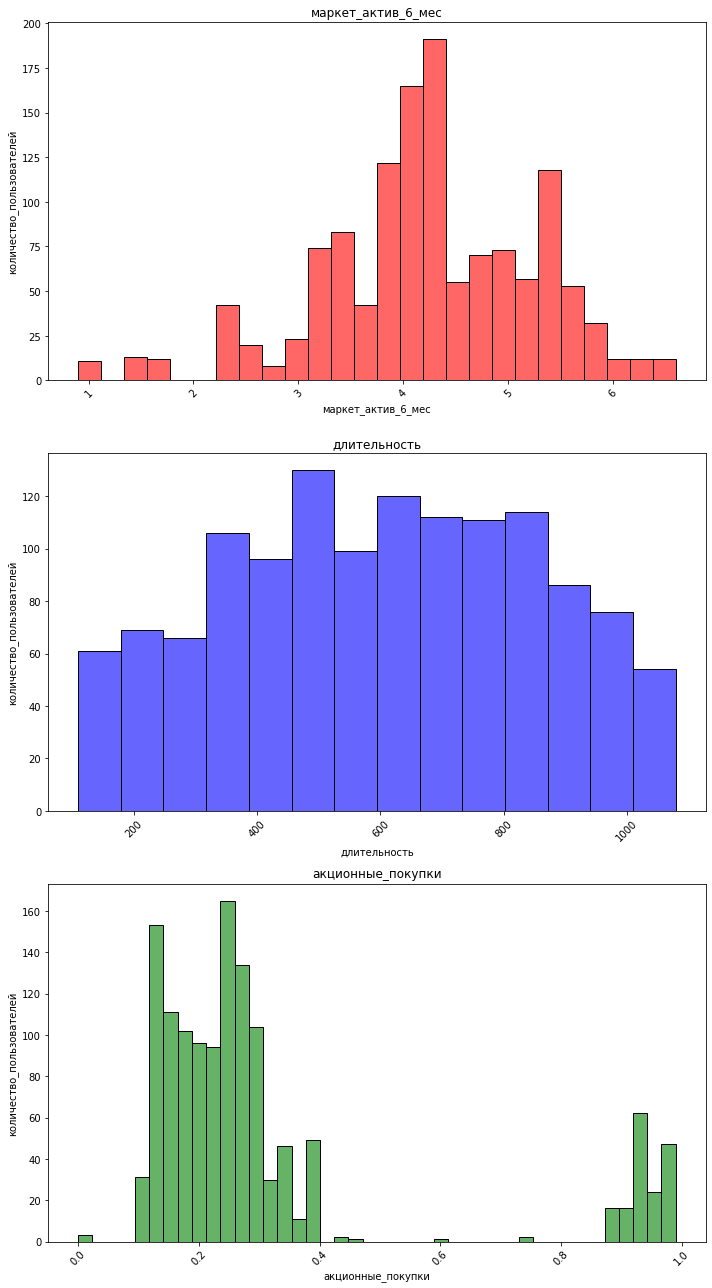

In [23]:
quant_cols = file_merged.select_dtypes(include="number").columns.to_list()
quant_cols.remove('id')
quant_cols = [item for item in quant_cols if item not in  descrete_cols]


colors = [
    "red",
    "blue",
    "green",
]

print(int((len(quant_cols) + 1) / 2))
fig, axs = plt.subplots(3, 1, figsize=(10, 18))
axs = axs.flatten()

for i in range(len(quant_cols)-1):
    sns.histplot(
        x=quant_cols[i],
        data=file_merged,
        ax=axs[i],
        color=colors[i],
        alpha=0.6
    )
    axs[i].set_title(quant_cols[i])
    axs[i].set_ylabel("количество_пользователей")
    axs[i].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()



- За 6 месяцев в среднем за месяц с клиентом взаимодействовали до 6 раз. Чаще всего - 4 раза. Выбросов не наблюдается.

- В текущем месяце было до 3 до 5 взаимодействий с каждым клиентов. Чаще всего - 4 раза. Выбросов не наблюдается.

- Данные о кол-ве времени со дня регистрации симметричны относительно значения в 600 дней. Плоский пик наблюдается в районе 400-800 дней. Это значит что больше всего пользователей пришло 400-800 дней назад, однако не все старые пользователи ушли, а новые тоже приходят.

- Гистограмма показывает, что есть два паттерна поведения среди клиентов - одни покупают только акционные продукты, другие - меньше уделяют значения акциям при формировании заказа.

- В течение последнего месяца пользователи в среднем просматривают от 1 до 6 категорий товаров. Обычно - это 3 категории за визит.

- По гистограмме заметно, что не у всех пользователей есть неоплаченные товары в корзине, однако у большинства они есть. Чаще всего их количество 2-3 товара.

- Большинство клиентов во время посещения сайтов сталкивали со сбоями, в среднем от 3 до 5 раз.

- За один визит на сайт большинство пользователей просматривает 5-7 страниц.

- Большинство клиентов приносит прибыль равную 5.

Посмотрим на категориальные столбцы.

In [24]:
display(file_merged.select_dtypes(exclude="number").describe().T)

,count,unique,top,freq
покупательская_активность,1300,2,прежний_уровень,802
тип_сервиса,1300,2,стандарт,924
разрешить_сообщать,1300,2,да,962
популярная_категория,1300,6,товары_для_детей,330


- У большинства пользователей покупательская активность осталась на прежем уровне.
- Самый популярный уровень сервиса - «стандарт».
- Большинство покупателей разрешили отправлять им дополнительные предложения о товаре.
- "Товары_для_детей" — самая популярная категория товаров у покупателя за последние 6 месяцев.



Рассмотрим пропорции популярных категорий среди клиентов.

In [25]:
display(pd.DataFrame(file_merged["популярная_категория"].value_counts(normalize=True)))

,популярная_категория
товары_для_детей,0.253846
домашний_текстиль,0.193077
косметика_и_аксесуары,0.171538
техника_для_красоты_и_здоровья,0.141538
мелкая_бытовая_техника_и_электроника,0.133846
кухонная_посуда,0.106154


После товаров для детей идут домашний текстиль и косметика. Найменее популярной категорией считается кухонная посуда.

Рассмотрим пропорции наглядно.

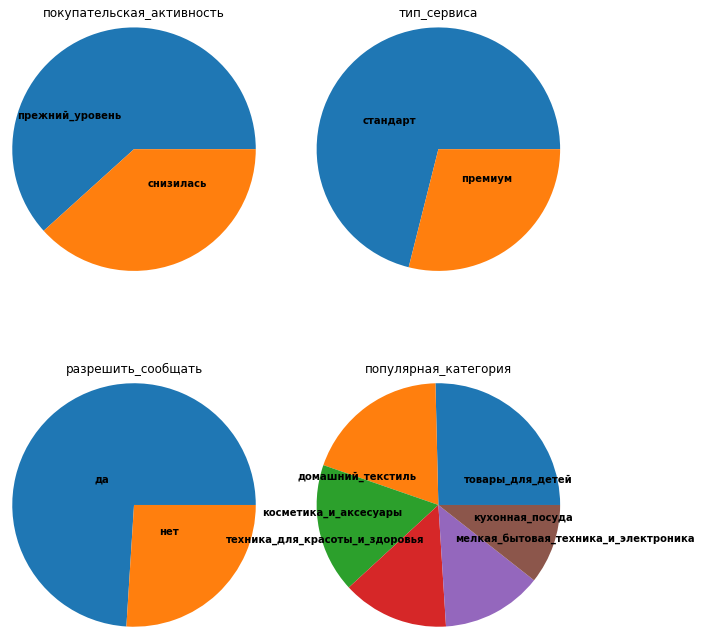

In [26]:
qual_cols = file_merged.select_dtypes(exclude="number").columns.to_list()

fig, axs = plt.subplots(int(len(qual_cols) / 2), 2, figsize=(10, 12))
axs = axs.flatten()

for i in range(len(qual_cols)):

    value_counts = market_file[qual_cols[i]].value_counts()
    axs[i].pie(
        value_counts,
        labels=value_counts.index,
        labeldistance=0.3,
        radius=1.2,
        textprops={"fontsize": 10, "weight": "bold"},
    )
    axs[i].set_title(qual_cols[i])

- У большинства клиентов покупательская активность не снизилась, хотя доля тех, чья активность снизилась, значительна (> 25%).
- Около 75% клиентов пользуются стандартными типо сервиса.
- Примерно столько же клиентов разрешили сообщать им о новостях/акциях магазина.

market_time
---

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

Исследуем количественные данные. 

In [27]:
display(market_time.select_dtypes(include="number").describe().T[1:])

,count,mean,std,min,25%,50%,75%,max
минут,2600.0,13.336154,4.080198,4.0,10.0,13.0,16.0,23.0


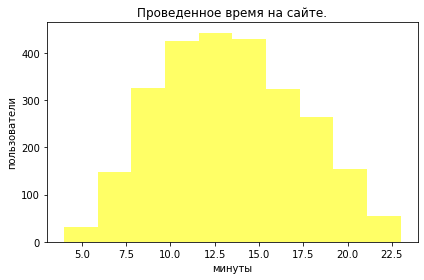

In [28]:
plt.hist(market_time["минут"], color="yellow", alpha=0.6, bins=10)
plt.title("Проведенное время на сайте.")
plt.xlabel("минуты")
plt.ylabel("пользователи")

# надо бы еще для каждого периода посмотреть


plt.tight_layout()
plt.show()

Данные очень симметричны, распределение близко к нормальному, выбросов не наблюдается. 

In [29]:
display(market_time.select_dtypes(exclude="number").describe().T)

,count,unique,top,freq
период,2600,2,предыдущий_месяц,1300


Наблюдений за предыдущий и текущий месяц поровну. 

market_money 
---

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. 

В таблице представлено 3 периода наблюдения: `препредыдущий`, `предыдущий`, `текущий`:


In [30]:
display(pd.DataFrame(market_money.период.value_counts()))

,период
предыдущий_месяц,1300
текущий_месяц,1300
препредыдущий_месяц,1300


In [31]:
display(market_money.select_dtypes(include="number").describe().T[1:])

,count,mean,std,min,25%,50%,75%,max
выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.0,106862.2


Данные представлены за 3 месяца о 1300 пользователях.

Данные сконцентрированы около значения 5000, они примерно симметричны. 
Однако, можно заметить большой разброс (высокое стандартное отклонение) и очень большое максимальное значение, что говорит о наличии выбросов.

Посмотрим, много ли значений, которые больше 10 000.

In [32]:
market_money.query("выручка > 10000")

,id,период,выручка
98,215380,текущий_месяц,106862.2


Оказывается, всего одна строка. Чтобы данное значение не мешало работе с данными, заменим его на медианное значение.

In [33]:
market_money.loc[market_money["выручка"] > 10000, ["выручка"]] = market_money[
    "выручка"
].median()

In [34]:
print(market_money["выручка"].median())

4957.25


Изучим распределение и разброс значений. 

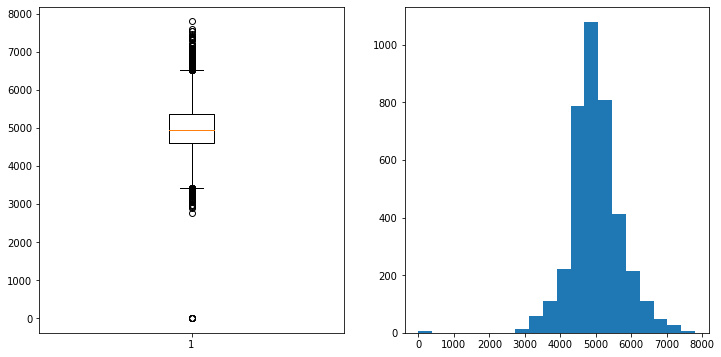

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].boxplot(market_money["выручка"])
axs[1].hist(
    market_money["выручка"],
    bins=20,
)
# p = market_money.query("выручка < 100000")
# plt.hist(p["выручка"], bins=20)
plt.show()

Данные распределены нормально с медианой и средним арифметическим в районе 5000. 

Некоторые значения лежат вне плотбокса, но довольно равномерно, их немало. Исклюение - нулевые значения. 

In [36]:
market_money.query("выручка == 0")

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


В выборку попали 6 значений -  о трех клиентах за предыдущий и препредыдущий месяц. Выручка равна нулю.

Проверим их выручку в текущем месяце. 

In [37]:
market_money.query("id in [215348, 215357, 215359]")

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
27,215357,текущий_месяц,5986.3
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
33,215359,текущий_месяц,4735.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Значения есть. Возможно, это клиенты которые пришли недавно. 
Исключать таких клиентов не будем, так как и для таких клиентов нужно поддерживать интерес, предлагать персонализированные предложения. 

In [38]:
id_to_deleta = market_money.query('выручка == 0')['id'].drop_duplicates().to_list()
market_money = market_money[~market_money['id'].isin(id_to_deleta)]
market_money

,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


На данном этапе мы удалим данные о пользователях, которые были неактивны.

Часть 2
---
Хотелось бы рассмотреть, как влияют разные значения в `file_merged` на целевой признак. 

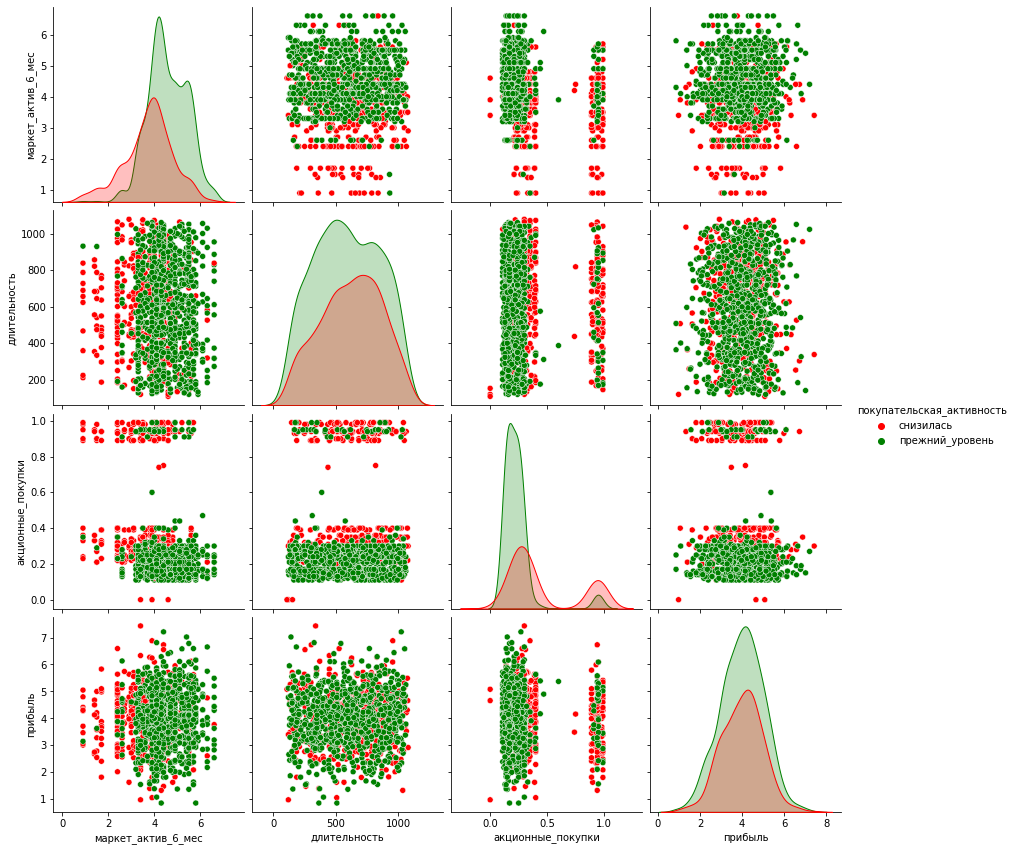

In [39]:
sns.pairplot(
    file_merged,
    vars=quant_cols,
    hue="покупательская_активность",
    height=3,
    aspect=1,
    palette={"снизилась": "red", "прежний_уровень": "green"},
)
plt.show()

Для клиентов с пониженной покупательской активностью характерны:
- низкий уровень маркетинговых контактов за последние 6 месяцев (маркет_актив_6_мес),
- меньшее количество просмотренных страниц за визит (страниц_за_визит),
- а также увеличенное число неоплаченных товаров в корзине (неоплаченные_продукты_штук_квартал).

Эти признаки могут указывать на потерю интереса к продуктам или неудовлетворённость пользовательским опытом.

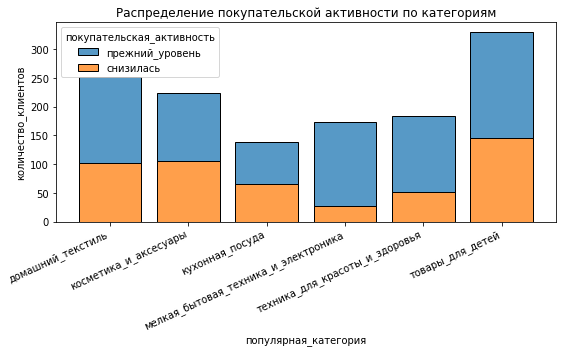

In [40]:
p = (
    file_merged.groupby(["популярная_категория", "покупательская_активность"])
    .size()
    .reset_index(name="количеcтво_клиентов")
)


plt.figure(figsize=(8, 5))
sns.histplot(
    data=p,
    x="популярная_категория",
    weights="количеcтво_клиентов",
    hue="покупательская_активность",
    multiple="stack",
    shrink=0.8,
    color={"снизилась": "red", "прежний_уровень": "green"},
)

plt.xticks(rotation=25, ha="right")
plt.ylabel("количеcтво_клиентов")
plt.title("Распределение покупательской активности по категориям")
plt.tight_layout()
plt.show()

Самые популярные категории среди покупателей - товары для детей и домашний текстиль. Высокая доля покупателей,  интересуют данные категории товаров, показывают сниженную активность.

Меньше всего покупательская активность снизилась среди покупателей мелкой бытовой техники и электроники, а также техники для красоты и здоровья. 


---

Вывод
-

Основные действия и наблюдения:
- Таблицы `market_file` и `money` были объединены по ключу `id` с использованием **внутреннего соединения**, при этом отобраны только клиенты, совершавшие покупки за последние три месяца (прибыль > 0).
- Все числовые признаки в объединённой таблице `file_merged` имели разумные распределения без значимых выбросов.
- Значения `акционные_покупки` смещены влево — большинство клиентов не ориентированы исключительно на акции.
- Большинство клиентов имеют «прежний уровень» активности, используют стандартный тип сервиса и разрешают маркетинговые уведомления.
- Категория `товары_для_детей` — самая популярная среди пользователей.

Таблица `market_time`:
- Данные представлены за два периода — текущий и предыдущий месяц, поровну.
- Среднее время пребывания на сайте — около 13 минут. Распределение нормальное, без выбросов.

Таблица  `market_money`:
- Данные представлены за три периода: препредыдущий, предыдущий и текущий месяцы. Всего 1300 уникальных клиентов.
- Обнаружен один значительный выброс (> 100000), заменён на медианное значение.
- Найдены три клиента с нулевой выручкой за 2 из 3 месяцев. Исключать их не стали, так как в текущем месяце они проявили активность.

Визуализация и анализ: 
- Анализ с помощью `pairplot` показал, что снижение покупательской активности связано с:
  - меньшим числом маркетинговых контактов;
  - меньшим числом просмотренных страниц за визит;
  - большим числом неоплаченных товаров в корзине.
- Клиенты, интересующиеся `мелкой_бытовой_техникой` и `техникой_для_красоты_и_здоровья`, демонстрируют устойчивую активность.
- Самые «уходящие» клиенты — те, кто интересуется `товарами_для_детей` и `домашним_текстилем`.

Результат:

В результате исследовательского анализа был сформирован чистый, объединённый датасет, включающий только активных клиентов. Проведённый анализ позволил выявить значимые поведенческие различия между пользователями с разной покупательской активностью. Выводы, сделанные на этом этапе, послужат основой для отбора признаков и дальнейшего построения моделей.

# Глава 4 

На этом этапе планируется объединить все доступные источники данных в одну итоговую таблицу, которая будет использоваться для дальнейшего моделирования. Для этого потребуется:
- Преобразовать таблицы `market_money` и `market_time` из длинного формата в широкий, создав отдельные столбцы для каждого периода;
- Объединить полученные таблицы с основной таблицей `market_file` по клиентскому идентификатору (`id`);
- Исключить таблицу `money.csv`, так как данные о прибыли не будут использоваться в модели.

In [1]:
market_time_upd = market_time.pivot(
    index="id", columns="период", values="минут"
).rename(
    columns={
        "предыдущий_месяц": "минут_пред_мес",
        "текущий_месяц": "минут_тек_мес",
    }
)

market_money_upd = market_money.pivot(
    index="id", columns="период", values="выручка"
).rename(
    columns={
        "препредыдущий_месяц": "выручка_препред_мес",
        "предыдущий_месяц": "выручка_пред_мес",
        "текущий_месяц": "выручка_тек_мес",
    }
)

full_df = market_file.merge(market_money_upd, on="id").merge(market_time_upd, on="id")

NameError: name 'market_time' is not defined

Выводы
-
-	Получен финальный датафрейм full_df, включающий все необходимые числовые и категориальные признаки для каждого клиента;
-	Данные о выручке и времени были развернуты в отдельные столбцы по каждому периоду, что обеспечит удобство при обучении моделей;
-	Таблица money.csv исключена из анализа, так как её целевой показатель уже присутствует в других источниках.


# Глава 5

На данном этапе будет проведён корреляционный анализ количественных признаков итоговой таблицы `full_df`. Задача — выявить:
- наличие сильных зависимостей между признаками,
- взаимосвязь признаков с целевым признаком (`покупательская_активность`),
- признаки с возможной мультиколлинеарностью, которые могут негативно повлиять на устойчивость модели.

Для анализа будут использованы:
- матрица корреляции φK (Phik) — для оценки связей между всеми типами признаков;
- корреляция Пирсона — для линейной связи между количественными признаками;
- коэффициент VIF — для выявления мультиколлинеарности.


In [42]:
interval_cols = full_df[['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'выручка_препред_мес', 'выручка_пред_мес', 'выручка_тек_мес']]


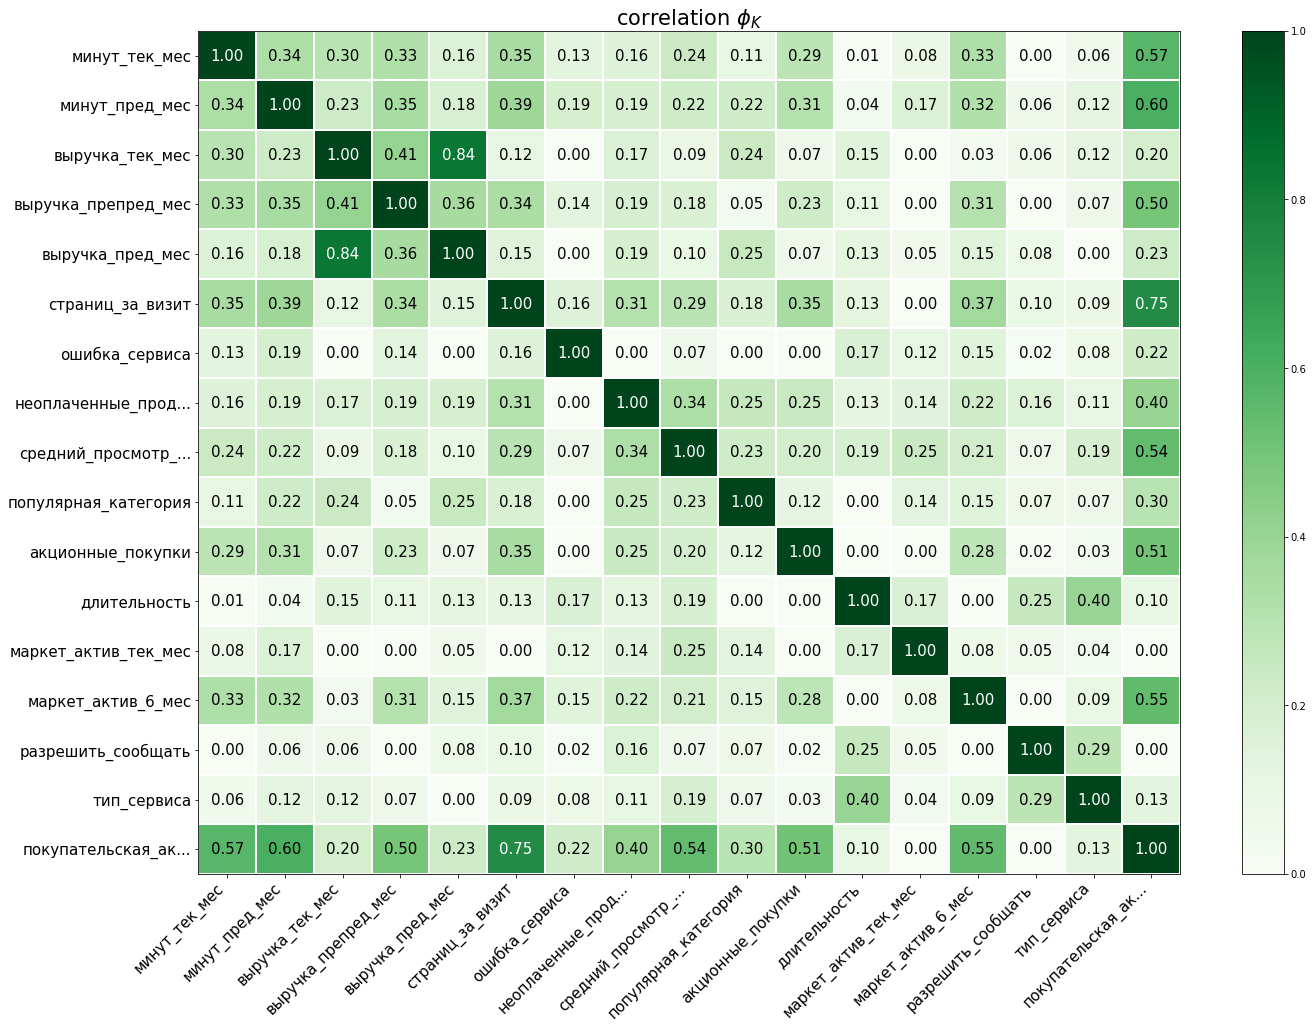

In [43]:
phik_overview = phik_matrix(full_df.iloc[:, 1:], interval_cols=interval_cols)


plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map="Greens",
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(20, 15),
)

plt.xticks(rotation=45, ha="right")
plt.show()

Заметим что фик корреляция обнаружила сильные взаимосвязи:

- для входных параметров между
  - `выручка_тек_мес` и `выручка_пред_мес`, `выручка_пред_мес` и `выручка_препред_мес`;
  - `акционные покупк`и и `ыручка_препред_мес`;
    
- для целевого признака (`покупательская_активность`) c
  - `страниц_за_визит`
  - `минут_пред_мес`
  - `минут_тек_мес`

Отсутсвие связи между целевым признаком и:
- `маркет_актив_тек_мес`
- `разрешить сообщать`



Для наглядности выведем корреляцию признаков в порядке убывания:

In [44]:
display(
    pd.DataFrame(
        phik_overview["покупательская_активность"][1:].sort_values(ascending=False)
    )
)

,покупательская_активность
страниц_за_визит,0.746825
минут_пред_мес,0.603903
минут_тек_мес,0.569310
маркет_актив_6_мес,0.546370
средний_просмотр_категорий_за_визит,0.539221
акционные_покупки,0.506991
выручка_препред_мес,0.495174
неоплаченные_продукты_штук_квартал,0.404382
популярная_категория,0.298036
выручка_пред_мес,0.227280


Построим матрицу линейной корреляции Пирсона непрерывных признаков:

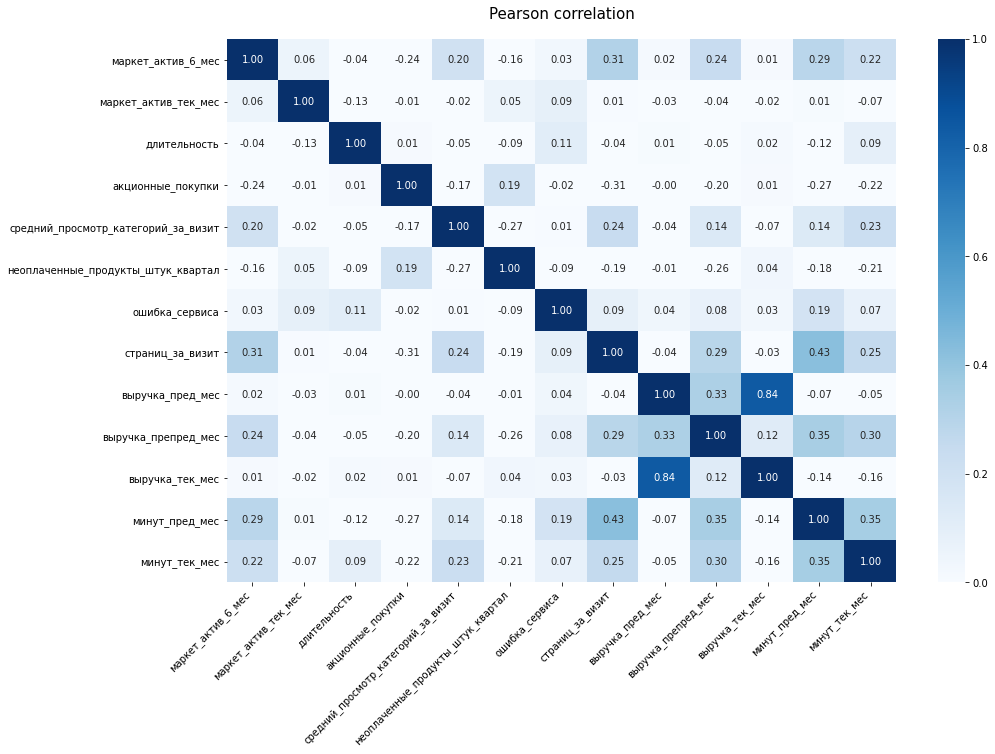

In [45]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    full_df.iloc[:, 1:].select_dtypes(include="number").corr(),
    annot=True,
    fmt=".2f",
    cmap="Blues",
    vmin=0,
    vmax=1,
)

plt.xticks(rotation=45, ha="right")

plt.title(r"Pearson correlation", fontsize=15, pad=20)
plt.show()

Заметим, что высокая линейная корреляция наблюдается между `выручка_тек_мес` и `выручка_пред_мес`. Однако близких к единицы значений корреляции нет.

VIF -  показатель мультиколлинеарности между признаками, который показывает, насколько один признак объясняется другими. 
VIF строит дополнительную регрессию, чтобы проверить, можно ли каждый из признаков предсказать с помощью остальных признаков. 

In [46]:
# Возмем количественные признаки
df_numeric = full_df.iloc[:, 1:].select_dtypes(include=[np.number])

# Масштабируем
X_scaled = StandardScaler().fit_transform(df_numeric)

# Создаём таблицу VIF
vif_data = pd.DataFrame()
vif_data["Признак"] = df_numeric.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])
]

# Сортируем
vif_data.sort_values("VIF", ascending=False, inplace=True)
vif_data.reset_index(drop=True, inplace=True)

display(vif_data)

,Признак,VIF
0,выручка_пред_мес,4.236125
1,выручка_тек_мес,3.870439
2,выручка_препред_мес,1.612442
3,минут_пред_мес,1.527000
4,страниц_за_визит,1.417205
5,минут_тек_мес,1.321109
6,маркет_актив_6_мес,1.222058
7,неоплаченные_продукты_штук_квартал,1.198187
8,акционные_покупки,1.186340
9,средний_просмотр_категорий_за_визит,1.178637


Умеренная мультиколлинеарность наблюдается при значении VIF равном 5. Все значения vif для признаков – ниже, поэтому удалять признаки не будем. 

# Выводы

- Явных проблем с мультиколлинеарностью не выявлено — все VIF < 5.
- Некоторые признаки показывают высокую информативность по отношению к целевому признаку (`страниц_за_визит`, `время на сайте`, `акционные_покупки`).
- Признаки `разрешить_сообщать` и `маркет_актив_тек_мес` могут быть менее значимыми, но их удаление пока не требуется — финальный отбор будет проведён на следующем этапе с помощью `SelectKBest`.



# Глава 5.5 - дисбаланс классов, baseline модель

В этой главе планируется:

- Оценить **дисбаланс классов** целевого признака `покупательская_активность`, чтобы определить подходящие метрики качества;
- Построить **базовую модель** на логистической регрессии — она станет ориентиром для дальнейшего улучшения;
- Оценить значение `DummyClassifier` как нижнюю границу качества;
- Использовать `LabelEncoder` для кодирования целевого признака, а также `Pipeline` для обработки числовых и категориальных признаков;
- Применить `SelectKBest` для выбора наиболее значимых признаков и оптимизации модели.

Следует оценить дисбаланс классов целевого признака. Главная цель этого - отобрать ключевую метрику, по которой будем оценивать предсказательную способность модель.

,покупательская_активность
прежний_уровень,61.69
снизилась,38.31


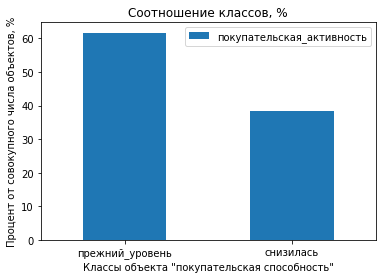

In [47]:
classes = round(pd.DataFrame(file_merged["покупательская_активность"].value_counts(normalize=True)) * 100,2)

classes.plot.bar(rot = 0)
plt.title('Соотношение классов, %');
plt.ylabel('Процент от совокупного числа объектов, %')
plt.xlabel('Классы объекта "покупательская способность"')
display(classes)

Отношение класса "прежний уровень" - 61.7%, а "снизилась" - 38.3%. 

Суть бизнес задачи - Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца. На этом основании покупателям будут предложены уникальные приложения. Это нужно для того, чтобы поддерживать вовлеченность клиентов.

Для компании важно найти всех, чей уровень покупательской активности может снизится. Если некоторые пользователи, чей уровень не снизился бы, получат специальное предложение - не так страшно. Однако специальные предложения могут значить недополучение денег, поэтому мы не можем предложить их всем. 

Все модели будут решать задачи бинарной классификации. 

Если покупательская активность снизилась - значит, что признак будет закодирован как единица, positive. Соответственно, метрики которые могут подойдти:
- recall (или лучше fbetta_score с большим весом для recall),
- с помощью roc_auc_score можно будет найти оптмальные весы,
- accuracy.



In [48]:
# Значит, что recall в 4 раза важнее
fbeta_2 = make_scorer(fbeta_score, beta=2, pos_label=1)


scoring = {
    "recall": "recall",
    "f2": fbeta_2,
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
}


Основной метрикой будет `recall`.

Dummy model
--

Построим Dummy model, чтобы посмотреть, какое значение метрики будет при присвоении всем значениям одного класса. 

In [49]:
X = full_df.drop(["id", "покупательская_активность"], axis=1)
y = full_df["покупательская_активность"]

TEST_SIZE = 0.25
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [50]:
le_dummy = LabelEncoder()
y_train_dummy = le_dummy.fit_transform(y_train)
y_test_dummy = le_dummy.transform(y_test)

In [51]:
dummy_model = DummyClassifier()
dummy_model = dummy_model.fit(X_train, y_train)
dummy_model_preds = dummy_model.predict(X_test)
dummy_model_probas = dummy_model.predict_proba(X_test)[:, 1]

display(accuracy_score(y_test, dummy_model_preds))

0.6184615384615385

Если мы всем клиентами присвоим, что их покупательская способность осталась на прежнем уровне, мы будем на 61.8% правы. 
Это — наивный базовый уровень, ниже которого в метрике `accuracy` ни одна модель не должна опускаться.

pipeline
-

Перед там, как перейти к базовой модели, создадим пайплайн для оптимизации работы с моделями.

Закодируем целевой признак:

In [52]:
le_base = LabelEncoder()

y_train = le_base.fit_transform(y_train)
y_test= le_base.transform(y_test)

In [53]:
num_columns = (
    full_df.select_dtypes(include="number").drop("id", axis=1).columns.to_list()
)

ohe_columns = ["популярная_категория"]
ord_columns = [ "тип_сервиса", "разрешить_сообщать"]

In [54]:
full_df[ohe_columns + ord_columns].head()

,популярная_категория,разрешить_сообщать,тип_сервиса
0,товары_для_детей,да,премиум
1,домашний_текстиль,нет,стандарт
2,товары_для_детей,да,стандарт
3,товары_для_детей,нет,стандарт
4,домашний_текстиль,да,стандарт


In [55]:
num_columns

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'выручка_пред_мес',
 'выручка_препред_мес',
 'выручка_тек_мес',
 'минут_пред_мес',
 'минут_тек_мес']

In [56]:
ohe_pipeline = Pipeline(
    [
        (
            "simple_imputer_ohe",
            (SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ),
        (
            "OneHotEncoder",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
        ),
    ]
)


ord_pipeline = Pipeline(
    [
        (
            "simple_imputer_ord_before",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
        (
            "OrdinalEncoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        ),
        (
            "simple_imputer_ord_after",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
    ]
)

# сначала создаём все степени и взаимодействия, а потом масштабируемвместе, учитывая разброс всех новых признаков.

num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
    ]
)

In [65]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipeline, ohe_columns),
    ('ord', ord_pipeline, ord_columns),
    ('num', num_pipeline, num_columns)
],
    remainder = 'passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocess', data_preprocessor),
        ('models', None)
    ]
)


Создадим базовую модель, от способностей которой будем отталкиваться. Возьмем Линейную регрессию, в которой дополнительно увеличим признаковое пространство с помощью полиномизации.

Также воспользуемся `OrdinalEncoder` для категориальных признаков, `StandardScaler` – для числовых. 
С помощью `LabelEncoder` закодируем целевой признак. 

baseline
-

In [66]:
score_baseline = cross_validate(
    pipe_final.set_params(models=LogisticRegression(random_state=RANDOM_STATE)),
    X_train,
    y_train,
    cv=5,
    scoring=scoring,
)

display(pd.DataFrame(score_baseline).agg(["std",'mean']).round(4).T[2:])


,std,mean
test_recall,0.0301,0.7548
test_f2,0.0246,0.7768
test_roc_auc,0.0101,0.9002
test_accuracy,0.0120,0.8673


<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
    
Закомментил этот кусок, считай удален. Тест сделаю только для финальной бейзлайн модели.
   
</div>

In [67]:
pipe_final.set_params(models=LogisticRegression(random_state=RANDOM_STATE))
pipe_final.fit(X_train, y_train)

coeffs_logreg = pd.DataFrame(
    {
        "feature": pipe_final.named_steps["preprocess"].get_feature_names_out(),
        "coefficients": pipe_final.named_steps['models'].coef_.flatten(),
    }
)

coeffs_logreg["direction"] = coeffs_logreg["coefficients"].apply(
    lambda x: "+" if x > 0 else "-"
)
coeffs_logreg["coefficients"] = coeffs_logreg["coefficients"].abs()


coeffs_logreg["feature"] = coeffs_logreg["feature"].str.replace(" ", "  *  ")

display(coeffs_logreg.sort_values(by="coefficients", ascending=False).head(15))

,feature,coefficients,direction
94,num__страниц_за_визит * минут_пред_мес,1.636789,+
19,num__минут_тек_мес,1.460499,-
14,num__страниц_за_визит,1.317152,-
79,num__неоплаченные_продукты_штук_квартал * вы...,1.262291,+
95,num__страниц_за_визит * минут_тек_мес,1.170915,+
90,num__страниц_за_визит^2,1.055932,+
89,num__ошибка_сервиса * минут_тек_мес,1.016567,+
108,num__минут_пред_мес^2,0.951500,+
107,num__выручка_тек_мес * минут_тек_мес,0.940229,-
18,num__минут_пред_мес,0.939775,-


Самыми информативными признаками для Логистической регрессии оказались:
- num__страниц_за_визит * минут_пред_мес
- минут_тек_мес
- неоплаченные продукты в корзине за квартал * выручка


SelectKBest(f_classif, k=k) выбирает k самых информативных признаков (по F-статистике) из всех, которые подаёт preprocessor.

Это помогает найти оптимальный баланс между:

-	достаточной информативностью,
-	отсутствием шума (overfitting),
-	и размерностью.

In [68]:
results = []

for k in range(5, 100):
    pipe_k = Pipeline([
        ("preprocess", data_preprocessor),
        ("select", SelectKBest(score_func=f_classif, k=k)),
        ("model", LogisticRegression(random_state=RANDOM_STATE)),
    ])

    cv_scores = cross_validate(pipe_k, X_train, y_train, cv=5, scoring=scoring)

    results.append({
        "k": k,
        "recall_cv": round(cv_scores["test_recall"].mean(), 4),
        "f2_cv": round(cv_scores["test_f2"].mean(), 4),
        "accuracy_cv": round(cv_scores["test_accuracy"].mean(), 4),
        "roc_auc_cv": round(cv_scores["test_roc_auc"].mean(), 4),
    })

results_df = pd.DataFrame(results).set_index("k")


In [69]:

display(results_df.sort_values(by="recall_cv", ascending=False).head(3))
display(results_df.sort_values(by="f2_cv", ascending=False).head(3))
display(results_df.sort_values(by="accuracy_cv", ascending=False).head(3))
display(results_df.sort_values(by="roc_auc_cv", ascending=False).head(3))
results_df = pd.DataFrame(results).set_index("k")


,recall_cv,f2_cv,accuracy_cv,roc_auc_cv
k,,,,
73,0.7763,0.7954,0.8755,0.9014
55,0.7763,0.7954,0.8755,0.9042
54,0.7763,0.7946,0.8734,0.9036


,recall_cv,f2_cv,accuracy_cv,roc_auc_cv
k,,,,
73,0.7763,0.7954,0.8755,0.9014
55,0.7763,0.7954,0.8755,0.9042
54,0.7763,0.7946,0.8734,0.9036


,recall_cv,f2_cv,accuracy_cv,roc_auc_cv
k,,,,
47,0.7682,0.7912,0.8786,0.9011
49,0.7682,0.7911,0.8786,0.9021
48,0.7682,0.7907,0.8776,0.9017


,recall_cv,f2_cv,accuracy_cv,roc_auc_cv
k,,,,
55,0.7763,0.7954,0.8755,0.9042
53,0.7709,0.7913,0.8745,0.9040
54,0.7763,0.7946,0.8734,0.9036


Впервую очередь нас интересует recall, после - f2 метрика. С помощью accuracy и roc_auc оцениваем общую предсказательную способность модели.

Лучшие значения метрик согласно иерархии достигаются при значении k = 58. 


Посмотрим топ 10 признаков, которые SelectKBest считает лучшими.

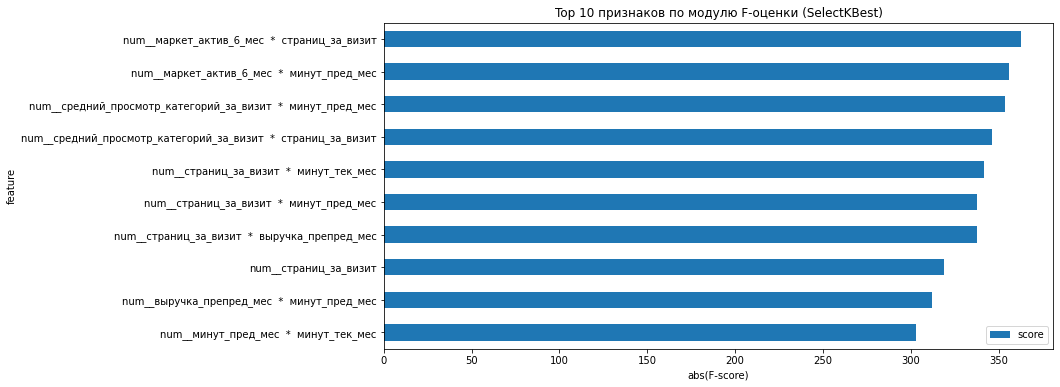

In [70]:
pipe_58 = Pipeline([
        ("preprocess", data_preprocessor),
        ("select", SelectKBest(score_func=f_classif, k=58)),
        ("model", LogisticRegression(random_state=RANDOM_STATE)),
    ])

pipe_58.fit(X_train, y_train) 


#Извлечем название признака и его скоринг
feature_names = pipe_58.named_steps["preprocess"].get_feature_names_out()
mask = pipe_58.named_steps["select"].get_support()
selected_features = feature_names[mask]
scores = pipe_58.named_steps["select"].scores_[mask]

# Объединяем в датафрейм
selected_df = pd.DataFrame({
    "feature": selected_features,
    "score": scores
})
selected_df["feature"] = selected_df["feature"].str.replace(" ", "  *  ")

top10 = selected_df.sort_values(by="score", key=abs).tail(10)

#Визуализируем
top10.plot(x="feature", y="score", kind="barh", figsize=(12, 6))
plt.title("Top 10 признаков по модулю F-оценки (SelectKBest)")
plt.xlabel("abs(F-score)")
plt.show()


Самыми информативными признаками для Логистической регрессии оказались с отобранными 58 признаками оказались: 
- num__страниц_за_визит * маркет активность 6 мес
- минут_тек_мес * маркет активность 6 мес
- средний просмотр категорий за визит * минут_пред_мес 

Выводы
-

- Целевой признак несбалансирован: ~62% пользователей не снизили активность, ~38% — снизили.
- Ключевая метрика — **recall**, так как бизнес-задача требует найти как можно больше клиентов с риском снижения активности. Для баланса точности и полноты применялась также **F2-score**.
- `DummyClassifier` показал baseline accuracy на уровне **≈61.8%** — это ориентир, ниже которого модели быть не должны.


- Метод `SelectKBest`  (k=58) значительно повысил интерпретируемость модели без потери качества. Среди наиболее информативных признаков оказались взаимодействия:
    - `маркет_активность_6_мес * страниц_за_визит`, 
    - `маркет_активность_6_мес * минут_пред_мес`, 
    - `выручка_тек_мес`.



# Глава 6

На этом этапе будет проведена системная подготовка данных и обучение нескольких моделей классификации для предсказания снижения покупательской активности. Вся обработка данных будет организована с использованием пайплайнов и ColumnTransformer, что позволит раздельно и гибко трансформировать числовые и категориальные признаки. Цель — сравнить качество различных моделей с учётом метрики Recall и выбрать лучшую для дальнейшего анализа.

Для подбора гиперпараметров всех моделей будет использована библиотека Optuna —  инструмент для автоматизированной оптимизации. В каждой задаче будет создана отдельная функция objective, в которую передастся параметры трансформации данных и модели. Optuna будет перебирать различные комбинации гиперпараметров, оценивая результат по кросс-валидации с метрикой Recall.

Для каждой модели будет построен собственный пайплайн, включающий как этапы подготовки данных, так и сам алгоритм обучения. Для автоматизированного подбора наилучших гиперпараметров будет использована библиотека Optuna, которая реализует подход байесовской оптимизации. Основная причина – исследовать пространство параметров, сокращая число итераций и находя более качественные решения по сравнению с простым перебором.

Использование TPESampler в Optuna ускорит подбор гиперпараметров за счёт приоритетного исследования наиболее перспективных областей пространства параметров. Это позволит быстро находить конфигурации, реально повышающие качество модели.


Логистическая регрессия 
-

Линейная модель классификации, предсказывающая вероятность принадлежности к классу на основе логистической функции. Хорошо работает на линейно разделимых данных, легко интерпретируется.

Модель обучалась на стратифицированной выборке, разбитой в пропорции 75/25.

Пайплайн обработки данных включает:
- Заполнение пропусков в числовых признаках (стратегия most_frequent);
- Создание полиномиальных признаков второй степени;
- Масштабирование числовых данных (StandardScaler или MinMaxScaler);
- Кодирование категориальных признаков: OneHotEncoder для номинативных и OrdinalEncoder для порядковых;
- Использование LabelEncoder для целевого признака.


In [71]:
def objective(trial):
    scaler_map = {"standard": StandardScaler(), "minmax": MinMaxScaler()}
    scaler_name = trial.suggest_categorical("scaler", ["standard", "minmax"])
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    solver = trial.suggest_categorical("solver", ['lbfgs', "liblinear", "saga", "newton-cg"])

    
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    C = trial.suggest_float("C", 1e-4, 100, log=True)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    intercept_scaling = trial.suggest_float("intercept_scaling", 0.1, 10.0, log=True)

    # Проверка совместимости penalty и solver
    valid_combinations = {
        "l1": ["liblinear", "saga"],
        "l2": ["liblinear", "saga", "lbfgs", "newton-cg"],
    }
    if solver not in valid_combinations.get(penalty, []):
        raise optuna.exceptions.TrialPruned()

    model_logreg = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        random_state=RANDOM_STATE,
        class_weight=class_weight,
        max_iter=4000,
        fit_intercept=fit_intercept,
        intercept_scaling=intercept_scaling
    )

    # Создаём копию уже существующего пайплайна и меняем только scaler
    pipe = clone(pipe_final)
    pipe.set_params(preprocess__num__scaler=scaler_map[scaler_name], models=model_logreg)

    cv_result = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring=scoring,
        return_train_score=False
    )

    trial.set_user_attr("metrics", {
        k: np.mean(v) for k, v in cv_result.items() if k.startswith("test_")
    })

    return cv_result["test_recall"].mean()

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials= 250, show_progress_bar=True)

[I 2025-06-11 18:16:54,899] A new study created in memory with name: no-name-41aa344b-48be-4bc9-a8fd-9bf01e42b1bb


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2025-06-11 18:16:54,938] Trial 0 pruned. 
[I 2025-06-11 18:16:57,146] Trial 1 finished with value: 0.7951351351351352 and parameters: {'scaler': 'minmax', 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 'C': 0.054502936945582565, 'fit_intercept': True, 'intercept_scaling': 1.0677482709481354}. Best is trial 1 with value: 0.7951351351351352.
[I 2025-06-11 18:17:10,743] Trial 2 finished with value: 0.752036036036036 and parameters: {'scaler': 'standard', 'penalty': 'l1', 'solver': 'saga', 'class_weight': None, 'C': 1.274671157821506, 'fit_intercept': True, 'intercept_scaling': 0.978033701665941}. Best is trial 1 with value: 0.7951351351351352.
[I 2025-06-11 18:17:23,747] Trial 3 finished with value: 0.7547387387387388 and parameters: {'scaler': 'minmax', 'penalty': 'l2', 'solver': 'saga', 'class_weight': None, 'C': 43.35045392775134, 'fit_intercept': True, 'intercept_scaling': 6.978281265126034}. Best is trial 1 with value: 0.7951351351351352.
[I 2025-06-11 18:17:25,749

Для улучшения качества модели был выполнен автоматизированный подбор гиперпараметров. Перебирались следующие параметры:

- тип масштабирования: StandardScaler или MinMaxScaler;
- тип регуляризации: l1, l2 или elasticnet;
- параметр регуляризации C (обратная сила штрафа);
- оптимизатор (solver): liblinear, saga, sag, lbfgs (в зависимости от penalty);
- параметр class_weight: либо без балансировки, либо balanced;
- при использовании elasticnet — дополнительный параметр l1_ratio, отвечающий за долю L1-регуляризации.
  
**Оптимизация:**
- Байесовская оптимизация (`TPESampler`);
- Целевая метрика: `recall`

In [72]:
best_params = study.best_trial.params





In [73]:
# Получим метрики лучших моделей
trials_logreg_df = pd.DataFrame([
    {
        **t.params,
        **t.user_attrs.get("metrics", {}),
    }
    for t in study.trials
    if t.state == optuna.trial.TrialState.COMPLETE
])

# Сортируем по accuracy
trials_logreg_df = trials_logreg_df.sort_values("test_recall", ascending=False)

# Отображаем топ-5
display(trials_logreg_df.head(20))

,scaler,penalty,solver,class_weight,C,fit_intercept,intercept_scaling,test_recall,test_f2,test_roc_auc,test_accuracy
197,standard,l1,liblinear,balanced,0.033808,False,5.050115,0.830234,0.813464,0.898000,0.831303
135,standard,l1,liblinear,balanced,0.019031,False,6.509845,0.830234,0.808355,0.894555,0.818969
154,standard,l1,liblinear,balanced,0.018978,False,0.398222,0.830234,0.808328,0.894645,0.818964
143,standard,l1,liblinear,balanced,0.030749,False,8.687053,0.830234,0.812600,0.897999,0.829247
26,standard,l1,liblinear,balanced,0.020417,False,4.369372,0.830234,0.810043,0.895607,0.823082
27,standard,l1,liblinear,balanced,0.038171,False,2.360359,0.830234,0.814333,0.898269,0.833365
78,standard,l1,liblinear,balanced,0.036390,False,1.680317,0.830234,0.813891,0.898245,0.832334
214,standard,l1,liblinear,balanced,0.038703,False,1.537692,0.830234,0.814333,0.898224,0.833365
165,standard,l1,liblinear,balanced,0.032837,False,4.733927,0.830234,0.813040,0.897977,0.830278
80,standard,l1,liblinear,balanced,0.032816,False,1.377839,0.830234,0.813040,0.898022,0.830278


In [74]:
best_linear_model = LogisticRegression(
    penalty='l1',
    C=0.011775,
    solver='liblinear',
    class_weight='balanced',
    random_state=RANDOM_STATE,
    max_iter=4000,
    fit_intercept=False,
    intercept_scaling=4.489482
)


Decision Tree model 
-


Дерево решений разбивает пространство признаков по порогам, создавая иерархию условий. Проста и наглядна, но может переобучаться без регуляризации.

Пайплайн обработки данных включает:
- Для числовых признаков создаются полиномиальные признаки второй степени без масштабирования;
- Для категориальных признаков используется OrdinalEncoder после замены пропусков на наиболее частое значение;
- Масштабирование числовых признаков для данной модели не нужно.

**Гиперпараметры, подбираемые с помощью Optuna:**
- `max_depth` — максимальная глубина дерева;
- `min_samples_split` — минимальное количество образцов для разделения узла;
- `min_samples_leaf` — минимальное количество образцов в листе;
- `max_features` — количество признаков, учитываемых при разделении;
- `class_weight` — балансировка классов (`None` или `'balanced'`).

**Оптимизация:**
- Байесовская оптимизация (`TPESampler`);
- Целевая метрика: `recall`

In [75]:
def objective(trial):

    max_depth = trial.suggest_int("max_depth", 2, 15)
    max_features = trial.suggest_float("max_features", 0.01, 0.5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 3, 6)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)

    model_tree = DecisionTreeClassifier(
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        random_state=RANDOM_STATE,
    )

    pipe = clone(pipe_final)
    
    # Отключаем ненужные трансформации и включаем OrdinalEncoder
    pipe.set_params(
        preprocess__num__scaler='passthrough',
        models=model_tree
    )

    cv_result = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring=scoring,
        return_train_score=False
    )

    trial.set_user_attr("metrics", {
        k: np.mean(v) for k, v in cv_result.items() if k.startswith("test_")
    })

    return cv_result['test_recall'].mean()

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200, show_progress_bar=True)


[I 2025-06-11 18:25:37,461] A new study created in memory with name: no-name-5e8d2163-2bd7-4cef-8fd9-d134f1a0b2f0


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-11 18:25:37,903] Trial 0 finished with value: 0.7197117117117117 and parameters: {'max_depth': 7, 'max_features': 0.4758500101408589, 'min_samples_leaf': 5, 'min_samples_split': 19}. Best is trial 0 with value: 0.7197117117117117.
[I 2025-06-11 18:25:38,218] Trial 1 finished with value: 0.7141981981981982 and parameters: {'max_depth': 4, 'max_features': 0.08643731496473929, 'min_samples_leaf': 3, 'min_samples_split': 27}. Best is trial 0 with value: 0.7197117117117117.
[I 2025-06-11 18:25:38,616] Trial 2 finished with value: 0.778954954954955 and parameters: {'max_depth': 10, 'max_features': 0.35695556312006227, 'min_samples_leaf': 3, 'min_samples_split': 30}. Best is trial 2 with value: 0.778954954954955.
[I 2025-06-11 18:25:38,940] Trial 3 finished with value: 0.7601441441441442 and parameters: {'max_depth': 13, 'max_features': 0.11404616423235531, 'min_samples_leaf': 3, 'min_samples_split': 7}. Best is trial 2 with value: 0.778954954954955.
[I 2025-06-11 18:25:39,310] Tri

In [76]:
# Получим метрики лучших моделей
trials_tree_df = pd.DataFrame([
    {
        **t.params,
        **t.user_attrs.get("metrics", {}),
    }
    for t in study.trials
    if t.state == optuna.trial.TrialState.COMPLETE
])

# Сортируем по accuracy
trials_tree_df = trials_tree_df.sort_values("test_recall", ascending=False)

# Отображаем топ-5
display(trials_tree_df.head(20))

,max_depth,max_features,min_samples_leaf,min_samples_split,test_recall,test_f2,test_roc_auc,test_accuracy
195,13,0.353621,6,21,0.800649,0.801666,0.884810,0.850849
177,13,0.353656,6,22,0.800649,0.801666,0.884810,0.850849
189,13,0.352555,6,21,0.800649,0.801666,0.884810,0.850849
191,13,0.357796,6,21,0.800649,0.801666,0.884810,0.850849
192,13,0.356013,6,21,0.800649,0.801666,0.884810,0.850849
193,13,0.354996,6,21,0.800649,0.801666,0.884810,0.850849
118,13,0.338562,3,19,0.800541,0.797937,0.866231,0.841565
99,13,0.341387,3,18,0.800541,0.798802,0.863928,0.843627
84,11,0.213025,3,21,0.797910,0.798188,0.865903,0.846720
126,12,0.356165,6,20,0.792613,0.791345,0.883599,0.839498


Модель DecisionTreeClassifier показала стабильные, но менее точные результаты по сравнению с логистической регрессией.

KNeighborsClassifier model
-

Алгоритм “k ближайших соседей” классифицирует объект на основе классов ближайших обучающих примеров. 

**Гиперпараметры, подобранные через Optuna:**

- `scaler` — метод масштабирования: `standard` или `minmax`;
- `n_neighbors` — количество ближайших соседей (от 1 до 30);
- `metric` — метрика расстояния:  
  - `euclidean` — Евклидово расстояние,  
  - `cityblock` — манхэттенское расстояние,  
  - `chebyshev` — расстояние Чебышёва,  
  - `minkowski` — обобщённая метрика;
- `p` — степень метрики Минковского (если выбрана `minkowski`, подбирается в диапазоне от 1 до 5);
- `weights` — способ взвешивания соседей: `uniform` (все равны) или `distance` (обратнопропорционально расстоянию).

**Оптимизация:**
- Байесовская оптимизация (`TPESampler`);
- Целевая метрика: `recall`

In [77]:
def objective(trial):

    scaler_map = {"standard": StandardScaler(), "minmax": MinMaxScaler()}
    scaler_name = trial.suggest_categorical("scaler", ["standard", "minmax"])

    n_neighbors = trial.suggest_int("n_neighbors", 3, 30)
    metric = trial.suggest_categorical(
        "metric", ["euclidean", "cityblock", "chebyshev", "minkowski"]
    )
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])

    if metric == "minkowski":
        p = trial.suggest_float("p", 1, 5)
    else:
        p = 2

    
    model_neighbors = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        metric=metric,
        weights=weights,
        p = p
    )

    pipe = clone(pipe_final)
    pipe.set_params(
        preprocess__num__scaler=scaler_map[scaler_name],
        models=model_neighbors
    )

    cv_result = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring=scoring,
        return_train_score=False
    )

    trial.set_user_attr("metrics", {
        k: np.mean(v) for k, v in cv_result.items() if k.startswith("test_")
    })
    
    return cv_result['test_recall'].mean()



sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=150, show_progress_bar=True)

[I 2025-06-11 18:26:58,673] A new study created in memory with name: no-name-ebdcd018-7f39-47f6-bdbf-dca97620c3d7


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-06-11 18:26:59,356] Trial 0 finished with value: 0.7305225225225225 and parameters: {'scaler': 'minmax', 'n_neighbors': 23, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 0 with value: 0.7305225225225225.
[I 2025-06-11 18:26:59,712] Trial 1 finished with value: 0.7843243243243243 and parameters: {'scaler': 'standard', 'n_neighbors': 30, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 1 with value: 0.7843243243243243.
[I 2025-06-11 18:27:03,380] Trial 2 finished with value: 0.7331171171171171 and parameters: {'scaler': 'standard', 'n_neighbors': 20, 'metric': 'minkowski', 'weights': 'uniform', 'p': 3.0569377536544464}. Best is trial 1 with value: 0.7843243243243243.
[I 2025-06-11 18:27:07,022] Trial 3 finished with value: 0.7331171171171171 and parameters: {'scaler': 'standard', 'n_neighbors': 20, 'metric': 'minkowski', 'weights': 'uniform', 'p': 1.3906884560255355}. Best is trial 1 with value: 0.7843243243243243.
[I 2025-06-11 18:27:07,557] Trial 4 fin

In [78]:
# Получим метрики лучших моделей
trials_neighbors_df = pd.DataFrame([
    {
        **t.params,
        **t.user_attrs.get("metrics", {}),
    }
    for t in study.trials
    if t.state == optuna.trial.TrialState.COMPLETE
])

trials_neighbors_df = trials_neighbors_df.sort_values(by = "test_recall", ascending=False)

# Отображаем топ-20
display(trials_neighbors_df.head(20))


,scaler,n_neighbors,metric,weights,test_recall,test_f2,test_roc_auc,test_accuracy,p
71,standard,5,cityblock,distance,0.808613,0.822326,0.898581,0.88580,NaN
111,standard,5,cityblock,distance,0.808613,0.822326,0.898581,0.88580,NaN
69,standard,5,cityblock,distance,0.808613,0.822326,0.898581,0.88580,NaN
70,standard,5,cityblock,distance,0.808613,0.822326,0.898581,0.88580,NaN
74,standard,5,cityblock,distance,0.808613,0.822326,0.898581,0.88580,NaN
68,standard,5,cityblock,distance,0.808613,0.822326,0.898581,0.88580,NaN
129,standard,8,cityblock,distance,0.808577,0.825406,0.906426,0.89299,NaN
124,standard,8,cityblock,distance,0.808577,0.825406,0.906426,0.89299,NaN
121,standard,8,cityblock,distance,0.808577,0.825406,0.906426,0.89299,NaN
120,standard,8,cityblock,distance,0.808577,0.825406,0.906426,0.89299,NaN


KNeighborsClassifier дал высокую точность и recall, особенно при k=6, но менее интерпретируем по сравнению с логистической регрессией.

SVC model
-


Метод опорных векторов строит границу максимального разделения между классами, может использовать различные ядра для нелинейного разделения. Рассмотрим оптимизацию для разных ядер. 

Оптимизация гиперпараметров с помощью Optuna:
- scaler – выбор способа нормализации числовых признаков: standard или minmax;
- kernel – тип ядра: linear, poly, rbf;
- C – коэффициент регуляризации (log-шкала от 0.1 до 10);
- gamma – коэффициент ширины гауссовой функции для rbf и poly (log-шкала от 0.1 до 10);
- degree – степень полинома для ядра poly (от 1 до 2).



**Оптимизация:**
- Байесовская оптимизация (`TPESampler`);
- Целевая метрика: `recall`

In [79]:
def objective(trial, kernel):

    scaler_map = {
        "standard": StandardScaler(),
        "minmax": MinMaxScaler()
    }
    scaler_name = trial.suggest_categorical("scaler", ["standard", "minmax"])

    C = trial.suggest_float("C", 0.1, 3, log=True)

    class_weight = trial.suggest_categorical(
        "class_weight", [None, "balanced"]
    )

    shrinking = trial.suggest_categorical(
        "shrinking", [True, False]
    )

    tol = trial.suggest_float(
        "tol", 1e-5, 1e-2, log=True
    )

    svc_params = dict(
        kernel=kernel,
        C=C,
        class_weight=class_weight,
        shrinking=shrinking,
        tol=tol
    )

    if kernel in ["rbf", "poly"]:
        svc_params["gamma"] = trial.suggest_float(
            "gamma", 0.01, 1, log=True
        )

    if kernel == "poly":
        svc_params["degree"] = trial.suggest_int(
            "degree", 2, 4
        )

    model_svc = SVC(**svc_params)

    pipe = clone(pipe_final)
    pipe.set_params(
        preprocess__num__scaler=scaler_map[scaler_name],
        models=model_svc
    )

    if kernel == "poly":
        pipe.set_params(preprocess__num__poly="passthrough")

    cv_result = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        n_jobs=-1,
        scoring=scoring,
        return_train_score=False
    )

    trial.set_user_attr(
        "metrics",
        {k: np.mean(v) for k, v in cv_result.items() if k.startswith("test_")}
    )

    return cv_result["test_recall"].mean()

[I 2025-06-11 18:28:43,078] A new study created in memory with name: no-name-639aea6e-f04e-41d4-a7b4-d8956b374196


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-06-11 18:28:43,503] Trial 0 finished with value: 0.0 and parameters: {'scaler': 'minmax', 'degree': 3, 'C': 0.7661100707771366, 'gamma': 0.020513382630874502}. Best is trial 0 with value: 0.0.
[I 2025-06-11 18:28:43,880] Trial 1 finished with value: 0.7763243243243244 and parameters: {'scaler': 'standard', 'degree': 3, 'C': 0.7725378389307354, 'gamma': 0.2607024758370766}. Best is trial 1 with value: 0.7763243243243244.
[I 2025-06-11 18:28:44,265] Trial 2 finished with value: 0.0 and parameters: {'scaler': 'minmax', 'degree': 3, 'C': 0.20589728197687912, 'gamma': 0.02310201887845294}. Best is trial 1 with value: 0.7763243243243244.
[I 2025-06-11 18:28:44,667] Trial 3 finished with value: 0.0 and parameters: {'scaler': 'minmax', 'degree': 3, 'C': 0.4345454109729476, 'gamma': 0.038234752246751866}. Best is trial 1 with value: 0.7763243243243244.
[I 2025-06-11 18:28:45,026] Trial 4 finished with value: 0.6765765765765765 and parameters: {'scaler': 'standard', 'degree': 2, 'C': 0.3

[I 2025-06-11 18:29:44,693] A new study created in memory with name: no-name-ffd95db6-fe65-4a5b-9aea-18d805eaeae7


[I 2025-06-11 18:29:44,690] Trial 149 finished with value: 0.7494054054054053 and parameters: {'scaler': 'minmax', 'degree': 3, 'C': 2.1087560698854686, 'gamma': 0.20176682149868516}. Best is trial 140 with value: 0.7843963963963965.


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-06-11 18:29:45,888] Trial 0 finished with value: 0.7332612612612613 and parameters: {'scaler': 'standard', 'degree': 3, 'C': 2.097821338457681, 'gamma': 0.15696396388661144}. Best is trial 0 with value: 0.7332612612612613.
[I 2025-06-11 18:29:46,366] Trial 1 finished with value: 0.735891891891892 and parameters: {'scaler': 'standard', 'degree': 2, 'C': 0.11662890273931381, 'gamma': 0.04473636174621265}. Best is trial 1 with value: 0.735891891891892.
[I 2025-06-11 18:29:46,910] Trial 2 finished with value: 0.7332612612612612 and parameters: {'scaler': 'standard', 'degree': 3, 'C': 0.33648671441879535, 'gamma': 0.036464395589807214}. Best is trial 1 with value: 0.735891891891892.
[I 2025-06-11 18:29:47,384] Trial 3 finished with value: 0.7385945945945946 and parameters: {'scaler': 'standard', 'degree': 3, 'C': 0.12886065671894004, 'gamma': 0.9413993046829938}. Best is trial 3 with value: 0.7385945945945946.
[I 2025-06-11 18:29:48,420] Trial 4 finished with value: 0.73326126126126

[I 2025-06-11 18:31:04,738] A new study created in memory with name: no-name-9385e610-d8dd-443a-aba9-13ac2aca0672


[I 2025-06-11 18:31:04,730] Trial 149 finished with value: 0.7332612612612613 and parameters: {'scaler': 'standard', 'degree': 3, 'C': 2.1250713554204173, 'gamma': 0.027611243022495475}. Best is trial 18 with value: 0.744.


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-06-11 18:31:05,485] Trial 0 finished with value: 0.6766486486486486 and parameters: {'scaler': 'minmax', 'degree': 2, 'C': 0.5639239991667558, 'gamma': 0.6533305220227736}. Best is trial 0 with value: 0.6766486486486486.
[I 2025-06-11 18:31:06,085] Trial 1 finished with value: 0.7331531531531532 and parameters: {'scaler': 'minmax', 'degree': 3, 'C': 0.21775224101934068, 'gamma': 0.014254757044027436}. Best is trial 1 with value: 0.7331531531531532.
[I 2025-06-11 18:31:06,857] Trial 2 finished with value: 0.05387387387387388 and parameters: {'scaler': 'standard', 'degree': 3, 'C': 1.5620386984526495, 'gamma': 0.18484491720988622}. Best is trial 1 with value: 0.7331531531531532.
[I 2025-06-11 18:31:07,645] Trial 3 finished with value: 0.1481081081081081 and parameters: {'scaler': 'standard', 'degree': 2, 'C': 2.081698684485893, 'gamma': 0.1198628179990118}. Best is trial 1 with value: 0.7331531531531532.
[I 2025-06-11 18:31:08,238] Trial 4 finished with value: 0.7331531531531532 

Для каждого из ядер (poly, linear, rbf) запускалась отдельная Optuna-оптимизация на 200 итераций с использованием кросс-валидации по метрике recall.

Результаты сохранялись отдельно для каждого ядра, чтобы сравнить лучшие модели по качеству.

In [80]:
for kern in kernels:
    trials_svc_df = (
        pd.DataFrame(
            [
                {
                    **t.params,
                    **t.user_attrs.get("metrics", {}),
                }
                for t in results[kern][0].trials
                if t.state == TrialState.COMPLETE 
            ]
        )
        .sort_values("test_recall", ascending=False)
        .reset_index(drop=True)
    )
    print(f"\n'{kern}'   :")
    display(trials_svc_df.head(5))


'poly'   :


,scaler,degree,C,gamma,test_recall,test_f2,test_roc_auc,test_accuracy
0,standard,3,2.455593,0.129723,0.784396,0.787332,0.885029,0.842591
1,standard,3,2.470993,0.129742,0.784396,0.787332,0.885096,0.842591
2,standard,3,2.487210,0.130971,0.781694,0.784559,0.884961,0.840534
3,standard,3,2.964846,0.181309,0.779027,0.777844,0.880741,0.829241
4,standard,3,2.888034,0.187658,0.779027,0.776572,0.881120,0.826159



'linear'   :


,scaler,degree,C,gamma,test_recall,test_f2,test_roc_auc,test_accuracy
0,minmax,3,1.467782,0.084627,0.744,0.776027,0.901467,0.883743
1,minmax,3,1.339395,0.041576,0.744,0.775600,0.901826,0.882712
2,minmax,3,1.742810,0.064182,0.744,0.776452,0.901068,0.884769
3,minmax,3,1.387172,0.065047,0.744,0.775600,0.901646,0.882712
4,minmax,3,1.463309,0.094433,0.744,0.776027,0.901467,0.883743



'rbf'   :


,scaler,degree,C,gamma,test_recall,test_f2,test_roc_auc,test_accuracy
0,minmax,3,2.408257,0.448544,0.78436,0.806085,0.908857,0.886836
1,minmax,3,2.703863,0.419163,0.78436,0.805188,0.909016,0.884779
2,minmax,3,2.409331,0.442070,0.78436,0.806085,0.908611,0.886836
3,minmax,3,2.589232,0.395631,0.78436,0.805636,0.908543,0.885810
4,minmax,3,2.760461,0.438114,0.78436,0.805188,0.909197,0.884779


In [81]:
study = results['rbf'][0]  
best_trial = study.best_trial
best_trial.params


#Trial 34 finished with value: 0.788828828828829 and parameters: {'scaler': 'minmax', 'degree': 2, 'C': 4.749105472552715, 'gamma': 0.4157477163531582}. Best is trial 34 with value: 0.788828828828829.

{'scaler': 'minmax',
 'degree': 3,
 'C': 2.5892320172535643,
 'gamma': 0.3956307138359165}

Сравнение моделей
-

In [82]:
print('В модели Linear Regression recall score на тренировочной - 0.8356')
print("Параметры лучшей модели :'scaler': 'standard', 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'C': 0.1238513729886093")
display(results_df.head()) # лин регр


print('В модели KNeighbors recall score на тренировочной - 0.808577')
display(trials_neighbors_df.head())


print('В модели Decision tree recall score на ттренировочнойесте - 0.80054')
display(trials_tree_df.head())


print('В модели SVC recall score на тесте - 0.8193 тренировочной, лучшие значения показало ядро rbf во второй степени')


В модели Linear Regression recall score на тренировочной - 0.8356
Параметры лучшей модели :'scaler': 'standard', 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'C': 0.1238513729886093


,recall_cv,f2_cv,accuracy_cv,roc_auc_cv
k,,,,
5,0.7602,0.7711,0.8447,0.8745
6,0.7656,0.7766,0.8488,0.8765
7,0.7655,0.7789,0.8539,0.8803
8,0.7520,0.7675,0.8498,0.8812
9,0.7494,0.7673,0.8539,0.8801


В модели KNeighbors recall score на тренировочной - 0.808577


,scaler,n_neighbors,metric,weights,test_recall,test_f2,test_roc_auc,test_accuracy,p
71,standard,5,cityblock,distance,0.808613,0.822326,0.898581,0.8858,NaN
111,standard,5,cityblock,distance,0.808613,0.822326,0.898581,0.8858,NaN
69,standard,5,cityblock,distance,0.808613,0.822326,0.898581,0.8858,NaN
70,standard,5,cityblock,distance,0.808613,0.822326,0.898581,0.8858,NaN
74,standard,5,cityblock,distance,0.808613,0.822326,0.898581,0.8858,NaN


В модели Decision tree recall score на ттренировочнойесте - 0.80054


,max_depth,max_features,min_samples_leaf,min_samples_split,test_recall,test_f2,test_roc_auc,test_accuracy
195,13,0.353621,6,21,0.800649,0.801666,0.88481,0.850849
177,13,0.353656,6,22,0.800649,0.801666,0.88481,0.850849
189,13,0.352555,6,21,0.800649,0.801666,0.88481,0.850849
191,13,0.357796,6,21,0.800649,0.801666,0.88481,0.850849
192,13,0.356013,6,21,0.800649,0.801666,0.88481,0.850849


В модели SVC recall score на тесте - 0.8193 тренировочной, лучшие значения показало ядро rbf во второй степени


SVC лучше всего показал себя с rbf-ядром, но уступил другим моделям по recall и оказался менее практичным в интерпретации.

---

Не смотря на то, что на тренировочных выборках линейная регрессия проигрывала другим моделям, на тестовой выборке модель показала себя лучшим образом. 

Метрика recall на тестовой выборке достигла 0.8387, что выше, чем у baseline модели, тоже линейной регрессии. Признаковое пространство было полиномизировано, так как полиномы второй степени входных параметров давали метрики лучше. Это связано с тем, что полиномы помогали уловить взаимосвязи для линейных моделей.

Для последующей работы и отбора признаков возьмем **Linear Regression** со следующими параметрами:
'scaler': 'minmax', 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced', 'C': 0.00775805117047789, 'fit_intercept': False, 'intercept_scaling': 3.7275315259082227

На следующем этапе постараемся улучшить метрики модели с помощью отбора признаков, оставив самые необходимые. 

Select K best
-

Select K best - метод отбора признаков на основе статистической значимости. Выбирает k признаков с наивысшими значениями оценки (в данном случае — f_classif, дисперсионный анализ).

In [83]:
final_results = []

# Перебираем k от 2 до количества признаков
for k in range(2, 80):
    pipe_k = Pipeline([
        ("preprocess", data_preprocessor),  # pipeline без SelectKBest
        ("select", SelectKBest(score_func=f_classif, k=k)),
        ("models", best_linear_model)
    ])

    cv_result = cross_validate(
        pipe_k,
        X_train,
        y_train,
        cv=3,
        n_jobs=-1,
        scoring=scoring,  # словарь метрик
        return_train_score=False
    )

    final_results.append({
        "k": k,
        "recall_train": round(cv_result["test_recall"].mean(), 4),
        "f2_train": round(cv_result["test_f2"].mean(), 4),
        "accuracy_train": round(cv_result["test_accuracy"].mean(), 4),
        "roc_auc_train": round(cv_result["test_roc_auc"].mean(), 4),
    })

final_results_df = pd.DataFrame(final_results).set_index("k")


In [84]:
display(final_results_df.sort_values(by="recall_train", ascending=False).head(10))
display(final_results_df.sort_values(by="f2_train", ascending=False).head(10))
display(final_results_df.sort_values(by="accuracy_train", ascending=False).head(10))
display(final_results_df.sort_values(by="roc_auc_train", ascending=False).head(10))


,recall_train,f2_train,accuracy_train,roc_auc_train
k,,,,
5,0.8301,0.7782,0.7428,0.8558
6,0.8274,0.7845,0.7644,0.8720
7,0.8274,0.7845,0.7644,0.8720
41,0.8247,0.7901,0.7829,0.8800
52,0.8247,0.7905,0.7840,0.8800
59,0.8247,0.7905,0.7840,0.8800
58,0.8247,0.7905,0.7840,0.8801
57,0.8247,0.7905,0.7840,0.8799
56,0.8247,0.7905,0.7840,0.8799


,recall_train,f2_train,accuracy_train,roc_auc_train
k,,,,
61,0.8247,0.7905,0.784,0.8799
69,0.8247,0.7905,0.784,0.8800
57,0.8247,0.7905,0.784,0.8799
58,0.8247,0.7905,0.784,0.8801
59,0.8247,0.7905,0.784,0.8800
54,0.8247,0.7905,0.784,0.8800
42,0.8247,0.7905,0.784,0.8800
53,0.8247,0.7905,0.784,0.8799
52,0.8247,0.7905,0.784,0.8800


,recall_train,f2_train,accuracy_train,roc_auc_train
k,,,,
61,0.8247,0.7905,0.784,0.8799
69,0.8247,0.7905,0.784,0.8800
57,0.8247,0.7905,0.784,0.8799
58,0.8247,0.7905,0.784,0.8801
59,0.8247,0.7905,0.784,0.8800
54,0.8247,0.7905,0.784,0.8800
42,0.8247,0.7905,0.784,0.8800
53,0.8247,0.7905,0.784,0.8799
52,0.8247,0.7905,0.784,0.8800


,recall_train,f2_train,accuracy_train,roc_auc_train
k,,,,
58,0.8247,0.7905,0.7840,0.8801
28,0.8247,0.7901,0.7829,0.8801
41,0.8247,0.7901,0.7829,0.8800
35,0.8247,0.7901,0.7829,0.8800
36,0.8247,0.7901,0.7829,0.8800
37,0.8247,0.7901,0.7829,0.8800
39,0.8247,0.7901,0.7829,0.8800
40,0.8247,0.7901,0.7829,0.8800
42,0.8247,0.7905,0.7840,0.8800


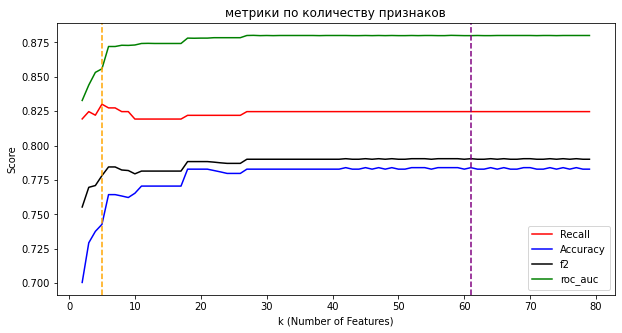

In [85]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(final_results_df.index, final_results_df['recall_train'], label='Recall', color='red')
ax1.plot(final_results_df.index, final_results_df['accuracy_train'], label='Accuracy', color='blue')
ax1.plot(final_results_df.index, final_results_df['f2_train'], label='f2', color='black')
ax1.plot(final_results_df.index, final_results_df['roc_auc_train'], label='roc_auc', color='green')
ax1.set_xlabel("k (Number of Features)")
ax1.set_ylabel("Score")
ax1.axvline(x=5, color='orange', linestyle='--', )
ax1.axvline(x=61, color='purple', linestyle='--')
ax1.legend()
plt.title("метрики по количеству признаков")

plt.show()


В данном случае лучше будет общий баланс,так как нам нужно учесть нетолько верность в предсказании одного класса, но и чтобы отрицательный класс несильно снизился, общие показатели модели тоже были в норме. Также мне кажется, что 5 признаков может быть недостаточно.

Поэтому 61 признак - будет оптимальным решением.


In [86]:
pipe_61 = Pipeline([                                               
        ("preprocess", data_preprocessor),                            
        ("select", SelectKBest(score_func=f_classif, k=61)),           
        ("models", best_linear_model
    ),
    ])

pipe_61.fit(X_train, y_train) 
y_pred = pipe_61.predict(X_test)
y_pred_proba = pipe_61.predict_proba(X_test)[:, 1]



mask = pipe_61.named_steps["select"].get_support()

features = pipe_61.named_steps["preprocess"].get_feature_names_out()

# Названия только отобранных признаков
selected_features = features[mask]

# Оценки для всех признаков
scores = pipe_61.named_steps["select"].scores_

# Оставляем только те, что прошли отбор
selected_scores = scores[mask]

# Собираем DataFrame
feature_scores = pd.DataFrame({
    'Feature': selected_features,
    'Score': selected_scores
}).sort_values(by='Score', ascending=False)

print(feature_scores)

                                              Feature       Score
11           num__маркет_актив_6_мес страниц_за_визит  362.981574
14             num__маркет_актив_6_мес минут_пред_мес  355.900313
36  num__средний_просмотр_категорий_за_визит минут...  353.772205
32  num__средний_просмотр_категорий_за_визит стран...  346.313885
50                num__страниц_за_визит минут_тек_мес  341.556774
..                                                ...         ...
31  num__средний_просмотр_категорий_за_визит ошибк...  105.048616
12           num__маркет_актив_6_мес выручка_пред_мес  102.664095
43                 num__ошибка_сервиса минут_пред_мес   99.361326
9        num__маркет_актив_6_мес маркет_актив_тек_мес   90.614915
44                  num__ошибка_сервиса минут_тек_мес   85.466700

[61 rows x 2 columns]


Перебор по k выявил оптимум при k = 61, что позволило улучшить метрики модели без потери качества и сократить размерность данных.

In [87]:
metrics_test = {
    "recall_test": round(recall_score(y_test, y_pred), 4),
    "f2_test": round(fbeta_score(y_test, y_pred, beta=2), 4),
    "accuracy_test": round(accuracy_score(y_test, y_pred), 4),
    "roc_auc_test": round(roc_auc_score(y_test, y_pred_proba), 4),
}

print(metrics_test)

{'recall_test': 0.8952, 'f2_test': 0.8645, 'accuracy_test': 0.8523, 'roc_auc_test': 0.9267}


Значения финальной модели на тестовой выборке - 
- recall_test': 0.8952, 
- 'f2_test': 0.8645, 
- 'accuracy_test': 0.8523, 
- 'roc_auc_test': 0.9267.

Вывод 
---

На данном этапе были построены полные пайплайны для предобработки данных и обучения моделей. Раздельная обработка числовых и категориальных признаков с использованием ColumnTransformer позволила гибко настраивать преобразования, а Pipeline обеспечил воспроизводимость и единообразие при обучении.

Для каждой из четырёх моделей (Logistic Regression, Decision Tree, KNN, SVC) был проведён подбор гиперпараметров с помощью Optuna по метрике Recall, что важно в задаче удержания клиентов — нам важно не упустить пользователей, чья активность может снизиться.

Обучены 4 модели:

1. *Logistic Regression*

2. *Decision Tree*

3. *KNeighborsClassifier*

4. *SVC (с ядрами poly, linear, rbf)*
- Перебирались: C, gamma, degree, scaler.


Наилучшие результаты показала логистическая регрессия с L2-регуляризацией, полиномиальными признаками и балансировкой классов. Эта модель также оказалась наиболее устойчивой и интерпретируемой. Её показатели на тренировочной выборке:
- Recall = 0.8356



*Дополнительно: отбор признаков*

С помощью SelectKBest с параметром f_classif проведена оценка важности признаков. Проведен перебор по k от 2 до 108:
- Максимальные значения recall и F2 достигнуты при k = 5 и k = 61.
- Выбрано 61 признака как оптимальное значение: хорошее качество модели без потери информативности.
- Построен итоговый пайплайн с отбором и переобучением Logistic Regression.


---

**Финальная модель: Logistic Regression + SelectKBest(k=61) показала на тестовой выборке**
- Recall = 0.8952
- F2-score = 0.8645
- Accuracy = 0.8523
- ROC AUC = 0.9267


# Глава 7. Анализ важности признаков


Оценим важность признаков для финальной модели с помощью двух методов:
- `Permutation importance` - помогает также оценить, как изменятся метрики,  перемешивая значения в каждом параметре.
- `SHAP` - дает однозначную оценку вклада признака в каждый прогноз, показывают значения Шепли, их оценивают методом SHAP (SHapley Additive exPlanations). Он вычисляет, как отдельный признак помог присвоить модели итоговое значение целевого.

In [88]:
# Финальный пайплайн
final_pipeline = clone(pipe_61)
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OneHotEncoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imputer...
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'выручка_пред_мес',
                                                   'выручка_препред_мес',
                                                   'выручка_тек_мес',
                                                   'минут_пред_мес',
                                                   'минут_тек_мес'])])),
                ('select', SelectKBest(k=61)),
                ('models',
                 LogisticRegression(C=0.011775, class_weight='balanced',
                                    fit_intercept=False,
                                    intercept_scaling=4.489482, max_iter=4000,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

Permutation importance
-


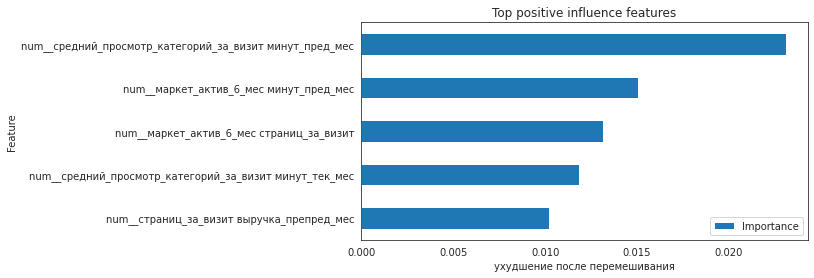

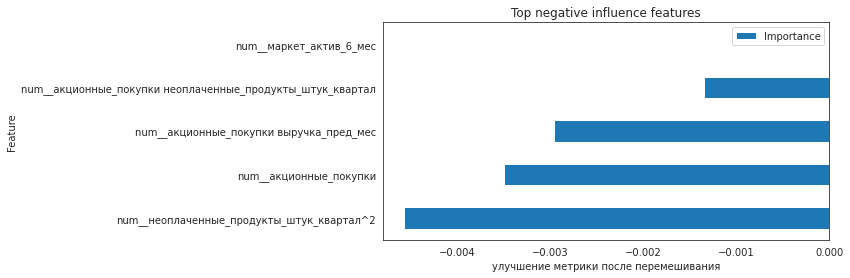

In [89]:
def custom_recall(model, X, y):
    y_pred = model.predict(X)
    score = recall_score(y, y_pred)
    return score

# Шаг 1: Применяем препроцессор
X_train_preprocessed = final_pipeline.named_steps["preprocess"].transform(X_train)
X_test_preprocessed = final_pipeline.named_steps["preprocess"].transform(X_test)

# Шаг 2: Применяем SelectKBest
selector = final_pipeline.named_steps["select"]
X_train_selected = selector.transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

# Шаг 3: Получаем имена фичей после отбора
all_feature_names = final_pipeline.named_steps["preprocess"].get_feature_names_out()
selected_mask = selector.get_support()
selected_feature_names = all_feature_names[selected_mask]

# Шаг 4: Вытаскиваем модель
model_inside = final_pipeline.named_steps["models"]

# Шаг 5: Permutation importance
result = permutation_importance(
    model_inside, 
    X_test_selected, 
    y_test, 
    scoring=custom_recall, 
    random_state=RANDOM_STATE, 
    n_repeats=30
)

# Шаг 6: Построение DataFrame
feature_importance = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': result['importances_mean']
}).sort_values('Importance')


sns.set_style('white')

# Top 5 positive
feature_importance.tail().plot(x='Feature', y='Importance', kind='barh', figsize=(8, 4))
plt.title('Top positive influence features')
plt.xlabel("ухудшение после перемешивания")

# Top 5 negative
feature_importance.head().plot(x='Feature', y='Importance', kind='barh', figsize=(8, 4))
plt.title('Top negative influence features')
plt.xlabel("улучшение метрики после перемешивания");

Важно разобраться со значениями, которые отдает `permutation_importance`:

	•	importance > 0 — признак помогает модели (его “ломание” ухудшает результат).
	•	importance = 0 — признак не влияет на метрику.
	•	importance < 0 — признак вредит модели (его “ломание” случайно улучшает результат).


Получается, что больше всего следующие признаки влияют на recall:
- средний просмотр категорий за визит * минут пред мес
- маркет актив 6 мес * минут пред мес;
- маркет актив 6 мес * страниц за визит;
- средний просмотр категорий за визит * минут тек мес;
- страниц за визит * выручка препред мес

"Мешают" метрике (в порядке убывания) хоть и незначительно:
- неоплаченные продукты  ^ 2
- акционные покупки
- акционные покупки *  выручка препред месяц 
- акционные покупки * неоплаченные продукты штук квартал


SHAP
-

Однозначную оценку вклада признака в каждый прогноз показывают значения Шепли, их оценивают методом SHapley Additive exPlanations. Он вычисляет, как отдельный признак помог присвоить модели итоговое значение целевого.

В данном случае как мы передадим нашу итоговую модель линейной регрессии, которая уже обучена. После этого получим значения Shap для каждого признака по каждому наблюдению.

- Изучим влияние признаков в тренировочной выборке для общей картины важности признаков.
- Посмотрим поведение модели также и на тестовой выборке, чтобы изучить поведение модели на новых данных.

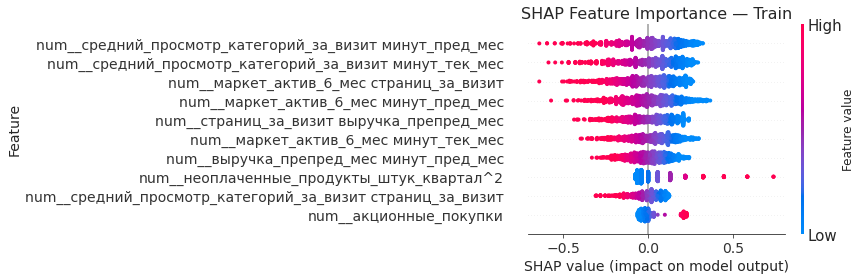

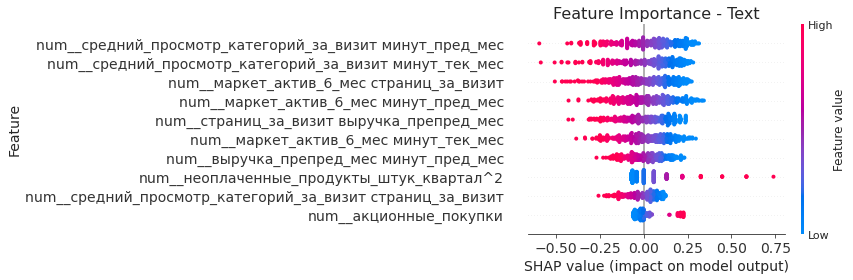

In [90]:
explainer = shap.LinearExplainer(model_inside, X_train_selected, feature_names=selected_feature_names)
shap_values_train = explainer(X_train_selected) 
shap_values_test = explainer(X_test_selected)


shap.summary_plot(
    shap_values_train,
    features=X_train_selected,
    feature_names=selected_feature_names,
    max_display=10,
    plot_size=(12, 4),
    show=False
)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
ax.set_title("SHAP Feature Importance — Train", fontsize=16)

cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Feature value", fontsize=12)

plt.tight_layout()
plt.show();


shap.summary_plot(
    shap_values_test,
    features=X_test_selected,
    feature_names=selected_feature_names,
    max_display=10,
    plot_size=(12, 4),
    show=False 
)

fig, ax = plt.gcf(), plt.gca()


ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
ax.set_title("Feature Importance - Text" , fontsize=16)

cb_ax.set_ylabel("Feature value", fontsize=16)

plt.tight_layout()
plt.show()
plt.show()

Распределения значений SHAP по признакам на тренировочной и тестовой выборках практически идентичны. Это свидетельствует о стабильности модели — важность признаков сохраняется при переходе к новым данным, что говорит о хорошем обобщении.

1. **средний просмотр категорий за визит × минут пред. месяца**  
   - При высоких значениях оказывает сильное влияние на предсказание.  
   - Большие значения увеличивают вероятность **нулевого класса** — т.е. с высокой вероятностью покупательская активность **не изменится**. 

2. **средний просмотр категорий за визит × минут текущего месяца**  
   - Аналогично: высокая активность по этому признаку также указывает на принадлежность к **нулевому классу** — стабильность покупательской активности.

3. **маркет актив 6 мес × страниц за визит**  
   - При росте значения возрастает влияние на отнесение объекта к **нулевому классу**.  
   - Указывает на устойчивое поведение клиента в долгосрочной маркетинговой активности.

4. **маркет актив 6 мес × минут пред. месяца**  
   - Повышенные значения также соответствуют **нулевому классу**.  
   - Это может свидетельствовать о привычной покупательской модели клиента, не подверженной снижению активности.
   
   
Поведенческие выводы по ключевым признакам

- Если пользователь **много изучает товары на сайте** и **тратит на это значительное время**, это **свидетельствует об интересе и вовлечённости**.  
С высокой вероятностью **его покупательская активность не снизится**.

- Если компания активно взаимодействует с пользователем **через маркетинговые каналы**, а пользователь в ответ **активно просматривает сайт**,  
Это говорит о **стабильном интересе к продукту** и предполагает, что **уровень покупок останется прежним**.   

С помощью `shap.plots.bar` изучим общий вклад признаков в прогнозы модели для обеих выборок.

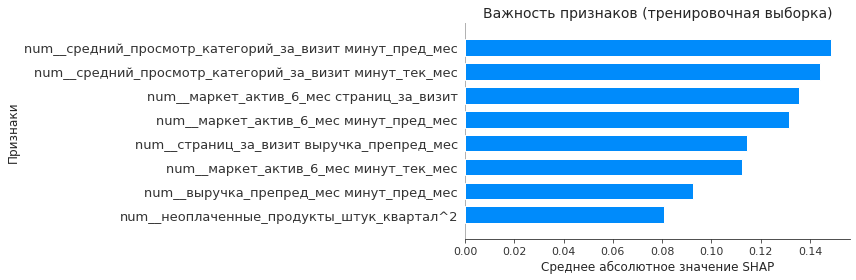

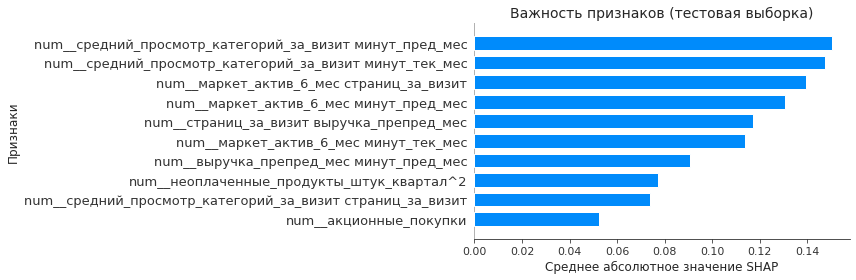

In [91]:
shap.summary_plot(
    shap_values_train,
    features=X_train_selected,
    feature_names=selected_feature_names,
    plot_type="bar",
    max_display=8,
    plot_size=(12, 4),
    show=False  # сначала не отображаем, чтобы добавить подписи
)

plt.title("Важность признаков (тренировочная выборка)", fontsize=14)
plt.xlabel("Среднее абсолютное значение SHAP", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.tight_layout()
plt.show()

# Тестовая выборка
shap.summary_plot(
    shap_values_test,
    features=X_test_selected,
    feature_names=selected_feature_names,
    plot_type="bar",
    max_display=10,
    plot_size=(12, 4),
    show=False
)

plt.title("Важность признаков (тестовая выборка)", fontsize=14)
plt.xlabel("Среднее абсолютное значение SHAP", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.tight_layout()
plt.show()

Наблюдается аналогичная картина. 

С помощью `shap.plots.waterfall` можно проанализировать некоторые наблюдения отдельно, чтобы понять какие признаки оказали бОльшее влияние на предсказание классификации.
Это особенно актуально для объектов, которых отнесли к неверному классу с большой вероятностью. Интересно изучить, какой признак привел к ошибке. 

Создадим 2 датафрейма, в котором будут значения признаков, реальный класс и предсказанная линейной регрессией вероятность. 
- false_negatives будет содержать ложно отрицательные. Модель уверена, что 0, но на самом деле 1.
- false_positives будет содержать ложно положительные. Модель уверена, что 1, но на самом деле 0.

In [92]:
# Получаем вероятности
y_pred_proba = model_inside.predict_proba(X_test_selected)[:, 1]
y_pred = model_inside.predict(X_test_selected)

# Создаём DataFrame
X_test_df = pd.DataFrame(X_test_selected, columns=selected_feature_names)
X_test_df['y_true'] = y_test
X_test_df['y_pred'] = y_pred
X_test_df['predict_proba'] = y_pred_proba

# False Negatives: модель уверена, что 0, но на самом деле 1
false_negatives = X_test_df[
    (X_test_df['y_true'] == 1) & 
    (X_test_df['y_pred'] == 0) & 
    (X_test_df['predict_proba'] <= 0.2)
].sort_values(by='predict_proba')

# False Positives: модель уверена, что 1, но на самом деле 0
false_positives = X_test_df[
    (X_test_df['y_true'] == 0) & 
    (X_test_df['y_pred'] == 1) & 
    (X_test_df['predict_proba'] >= 0.7)
].sort_values(by='predict_proba')

# Посмотреть все признаки + вероятность
print(" False Negatives (уверенные ошибки):")
display((false_negatives[selected_feature_names.tolist() + ['predict_proba']]))


 False Negatives (уверенные ошибки):


,num__маркет_актив_6_мес,num__акционные_покупки,num__средний_просмотр_категорий_за_визит,num__неоплаченные_продукты_штук_квартал,num__страниц_за_визит,num__выручка_препред_мес,num__минут_пред_мес,num__минут_тек_мес,num__маркет_актив_6_мес^2,num__маркет_актив_6_мес маркет_актив_тек_мес,...,num__выручка_пред_мес минут_тек_мес,num__выручка_препред_мес^2,num__выручка_препред_мес минут_пред_мес,num__выручка_препред_мес минут_тек_мес,num__выручка_тек_мес минут_пред_мес,num__выручка_тек_мес минут_тек_мес,num__минут_пред_мес^2,num__минут_пред_мес минут_тек_мес,num__минут_тек_мес^2,predict_proba
55,1.974204,-0.718712,1.289002,-0.929281,1.200237,0.253302,0.870652,-0.048641,2.405268,1.497868,...,0.096784,0.218782,0.835861,-0.014025,1.076213,0.154033,0.811935,0.404908,-0.197178,0.128842
201,0.525812,-0.598120,2.029493,-0.422969,0.188415,1.064607,0.114375,1.384048,0.452539,0.380030,...,2.116077,1.058786,0.317496,1.552167,0.247053,1.504717,-0.029286,0.906612,1.457716,0.194959


Рассмотрим объекты, которые являются объектами класса 1, но были отнесены к классу 0. То есть ошибки второго уровня.
В данном случае важно понять, какие признаки послужили причиной. 
Возьмем объекты, которым модель присвоила самую низкую вероятность оказаться в классе 1, хотя они принадлежат к классу 1. 

False Negatives: 2


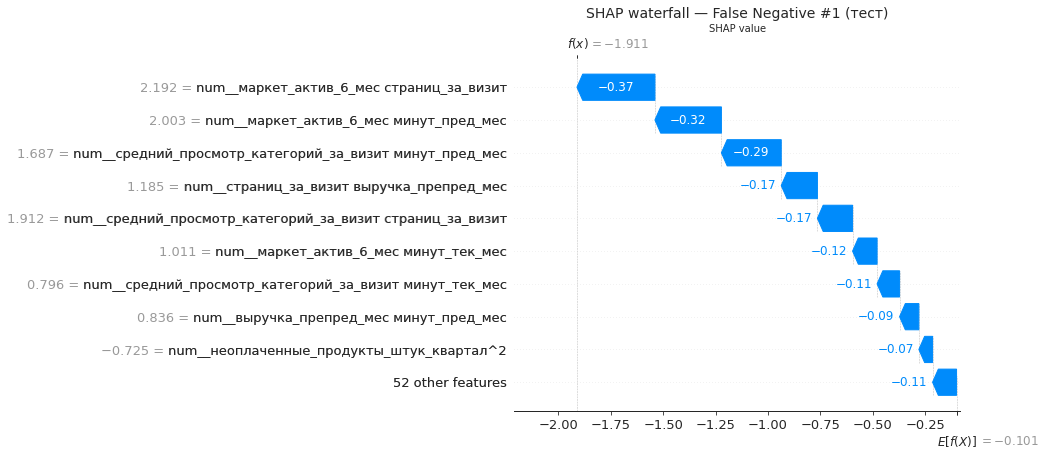

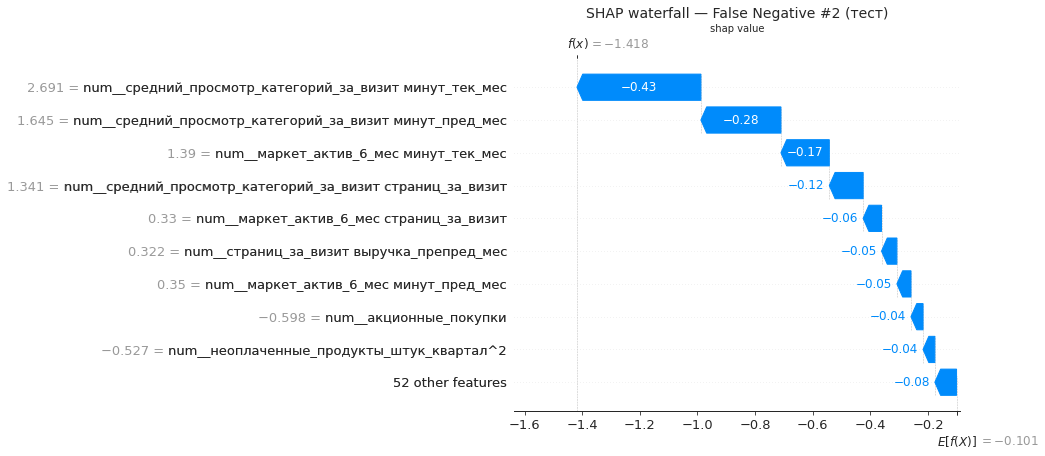

In [93]:
## # Индексы уверенных False Negatives
top_fn_indices =false_negatives.index.tolist()

print(f"False Negatives: {len(top_fn_indices)}")

# Первый пример
shap.plots.waterfall(
    shap_values_test[top_fn_indices[0]],
    max_display=10,
    show=False
)
plt.title("SHAP waterfall — False Negative #1 (тест)", fontsize=14)
plt.xlabel('SHAP value')

plt.show();

# Второй пример
shap.plots.waterfall(
    shap_values_test[top_fn_indices[1]],
    max_display=10,
    show=False
)
plt.title("SHAP waterfall — False Negative #2 (тест)", fontsize=14)
plt.xlabel('shap value')

plt.show()

Заметим, что E[f(X)] изначально отрицательная, возможно это связано с дисбалансом классов. Это значит, что в среднем объект принадлежит классу 0. 

Выделил признаки, которые неоднократно сильно повлияли: 
- маркет активн 6 мес * страниц за визит
- средний рпосмотр категорий за визит * минут тек мес

Рассмотрим те объекты, которые неверно отнесли к классу 1 вместо 0. Они нас тоже беспокоят, так как у таких ошибок есть свои издержки.

In [94]:
print(" False Positives (уверенные ошибки):")
display(false_positives[selected_feature_names.tolist() + ['predict_proba']])


 False Positives (уверенные ошибки):


,num__маркет_актив_6_мес,num__акционные_покупки,num__средний_просмотр_категорий_за_визит,num__неоплаченные_продукты_штук_квартал,num__страниц_за_визит,num__выручка_препред_мес,num__минут_пред_мес,num__минут_тек_мес,num__маркет_актив_6_мес^2,num__маркет_актив_6_мес маркет_актив_тек_мес,...,num__выручка_пред_мес минут_тек_мес,num__выручка_препред_мес^2,num__выручка_препред_мес минут_пред_мес,num__выручка_препред_мес минут_тек_мес,num__выручка_тек_мес минут_пред_мес,num__выручка_тек_мес минут_тек_мес,num__минут_пред_мес^2,num__минут_пред_мес минут_тек_мес,num__минут_тек_мес^2,predict_proba
269,-1.791615,-0.356937,-0.191979,0.589656,-0.570451,0.038545,-0.893994,0.190141,-1.574076,-1.40851,...,0.614006,0.003974,-0.826794,0.16278,-0.271319,0.947731,-0.897643,-0.49816,0.035541,0.704832


False Positives: 1


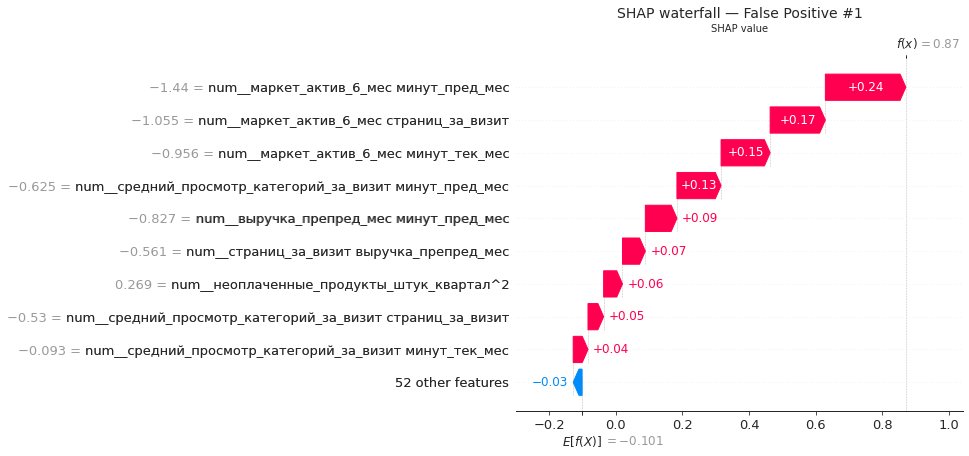

In [95]:
top_fp_indices =false_positives.index.tolist()
print(f"False Positives: {len(top_fp_indices)}")

shap.plots.waterfall(shap_values_test[top_fp_indices[0]], max_display=10,
                        show=False
)
plt.title("SHAP waterfall — False Positive #1", fontsize=14)
plt.xlabel('SHAP value')

plt.show();



Низкие значения в этих параметрах создают перевес, из которого могут быть допущены дополнительные ошибки:

- маркет активн 6 мес * страниц за визит
- маркет активн 6 мес * минут пред мес * минут тек мес
- маркет активн 6 мес * минут пред мес



## Вывод по SHAP-анализу и ошибкам модели

### Общая важность признаков

Распределения SHAP-значений на тренировочной и тестовой выборках практически идентичны. Это говорит о **стабильности модели** и её способности **обобщать** на новые данные.

Наиболее важные признаки по средней абсолютной важности (SHAP bar plot):

1. **средний просмотр категорий за визит × минут пред. месяца**  
   • При высоких значениях оказывает сильное влияние на предсказание.  
   • Большие значения увеличивают вероятность нулевого класса — т.е. покупательская активность не изменится.

2. **средний просмотр категорий за визит × минут текущего месяца**  
   • Высокая активность также указывает на стабильность покупательской активности.

3. **маркет актив 6 мес × страниц за визит**  
   • При росте значения возрастает влияние на отнесение объекта к нулевому классу.  
   • Указывает на устойчивое поведение клиента в долгосрочной маркетинговой активности.

4. **маркет актив 6 мес × минут пред. месяца**  
   • Повышенные значения соответствуют нулевому классу.  
   • Может свидетельствовать о стабильной, привычной модели покупок.

---

### Анализ уверенных ошибок

#### **False Negatives**  
(Модель уверена, что активности не будет, но она будет):

- Пользователи демонстрируют **высокую вовлечённость**, но модель ошибочно относит их к классу 0.
- Наиболее влиятельные признаки в этих ошибках:
  - `маркет актив 6 мес × страниц за визит`
  - `средний просмотр категорий за визит × минут текущего месяца`

#### **False Positives**  
(Модель уверена, что активность сохранится, но она снижается):

- Пользователи имеют **низкую активность**, но модель даёт высокий скор.
- Основные влияющие признаки:
  - `маркет актив 6 мес × страниц за визит`
  - `маркет актив 6 мес × минут пред. месяца`
  - `маркет актив 6 мес × минут пред. месяца × минут текущего месяца`

---

### Поведенческие выводы

- Пользователи, которые **много изучают сайт и тратят на это время**, с высокой вероятностью **не теряют интерес** и сохраняют активность.
- **Активное маркетинговое взаимодействие** + вовлечённость пользователя = **стабильность покупательского поведения**.
- Ошибки модели чаще возникают:
  - при **высокой активности без конверсии** (false negatives),
  - или при **исторически активных пользователях с текущим спадом** (false positives).

---

### Практическое применение

- SHAP-анализ помогает не только интерпретировать модель, но и:
  - находить слабые места,
  - формулировать **бизнес-правила** (например, усиливать маркетинг для вовлечённых, но снижающих покупки),
  - строить **персонализированные объяснения** для действий модели в продукте.

# Шаг 8. Сегментация покупателей

На данном шаге будет выделен сегмент покупателей, проанализировав который, будет составлено предложение, как увеличить покупательскую активность покупателей из этого сегмента.

Сегмент: Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

На данном этапе мы формируем финальный сегмент пользователей, объединяя несколько условий:

- Отбираем клиентов, у которых доля акционных покупок превышает 60%
- Предсказываем вероятность снижения покупательской активности с помощью обученного pipeline (`pipe_61`)  
- Оставляем только high-risk клиентов — тех, у кого `predict_proba > 0.8`. Т.е тех, чья активность может снизиться с большой вероятностью. 
- Объединяем с таблицей `money`, чтобы учитывать прибыль по каждому клиенту



Используем обученную модель, чтобы предсказать вероятность снижения покупательской активности именно для выделенного сегмента клиентов

In [96]:
segment_df = full_df[full_df["акционные_покупки"] > 0.6].copy()
X_segment = segment_df.drop(["id", "покупательская_активность"], axis=1)
segment_df["predict_proba"] = pipe_61.predict_proba(X_segment)[:, 1]

Выберем только тех клиентов с высокой долей акционных покупок, у кого высокая вероятность , с точки зрения модели, снизить покупательскую активность.

In [97]:
high_risk_segment = segment_df[segment_df["predict_proba"] > 0.8].copy()
high_risk_segment = high_risk_segment.merge(money[["id", "прибыль"]], on="id", how="inner")

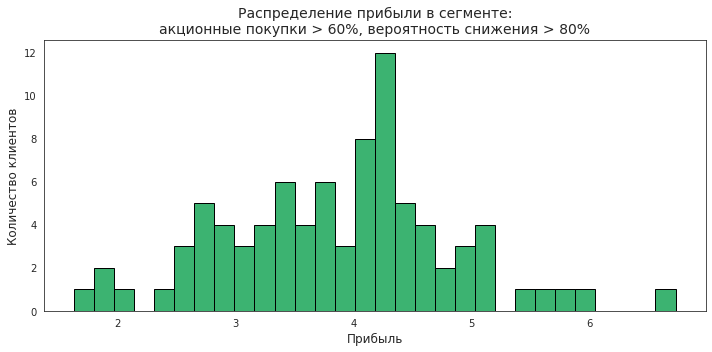

In [98]:
plt.figure(figsize=(10, 5))
plt.hist(high_risk_segment["прибыль"], bins=30, edgecolor='black', color='mediumseagreen')
plt.title("Распределение прибыли в сегменте:\пакционные покупки > 60%, вероятность снижения > 80%", fontsize=14)
plt.xlabel("Прибыль", fontsize=12)
plt.ylabel("Количество клиентов", fontsize=12)
plt.tight_layout()
plt.show()

Отберем клиентов, кто показывают значительную прибыль - больше 2.5 у.е.

In [103]:
segment_risk_df = high_risk_segment[high_risk_segment["прибыль"] > 2.5].copy()

In [118]:
segment_risk_df["прибыль"].describe()

count    80.000000
mean      3.999625
std       0.844356
min       2.540000
25%       3.377500
50%       4.025000
75%       4.462500
max       6.730000
Name: прибыль, dtype: float64

В нашем сегменте средняя прибыль равна 4. 

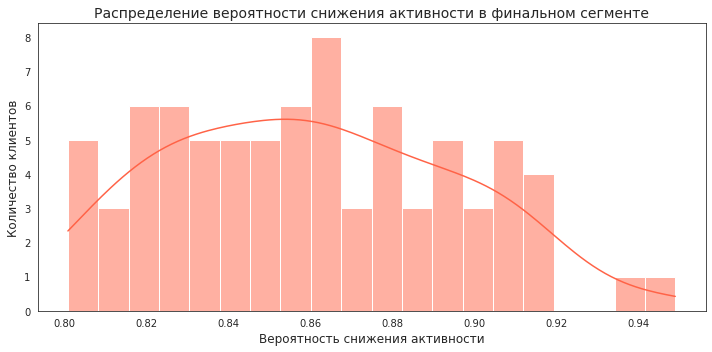

In [104]:
plt.figure(figsize=(10, 5))
sns.histplot(segment_risk_df["predict_proba"], bins=20, kde=True, color='tomato')
plt.title("Распределение вероятности снижения активности в финальном сегменте", fontsize=14)
plt.xlabel("Вероятность снижения активности", fontsize=12)
plt.ylabel("Количество клиентов", fontsize=12)
plt.tight_layout()
plt.show()

Модель чаще присваевает вероятность от 0.8 до 0.9. Выше - очень редко в нашем сегменте.

Посмотрим, как распределено отношение акционных покупок ко всем покупкам среди всех пользователей.

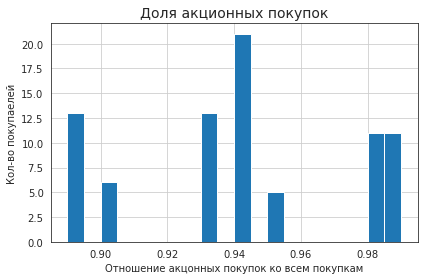

In [114]:
segment_risk_df['акционные_покупки'].hist(bins = 20);
plt.title("Доля акционных покупок", fontsize=14)
plt.xlabel('Отношение акцонных покупок ко всем покупкам')
plt.ylabel('Кол-во покупаелей')
plt.tight_layout()
plt.show()

Заметим, что, учитывая вероятность и прибыль, остались лишь те покупатели, у кого доля акционных покупок начинается от 0.89. 

Изучим самые популярные категории товаров среди тех клиентов, для кого важны акции.

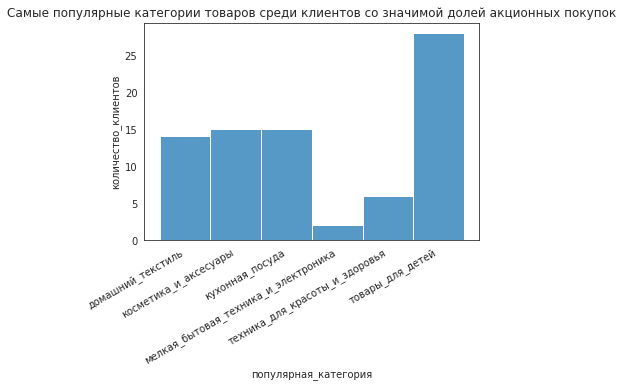

In [115]:

categories_discount_only = (
    segment_risk_df.groupby(["популярная_категория"])
    .size()
    .reset_index(name="количеcтво_клиентов")
)


sns.histplot(
    categories_discount_only, x="популярная_категория", weights="количеcтво_клиентов"
)
plt.title(
    "Самые популярные категории товаров среди клиентов со значимой долей акционных покупок"
)
plt.ylabel("количеcтво_клиентов")
plt.xticks(rotation=30, ha="right")
plt.show();


Самые популярные категории товаров среди клиентов со значимой долей акционных покупок - товары для детей. Следом идут косметика и аксессуары, кухонная посуда. 

Можно сделать вывод, что в этом сегменте больше женщин, чем мужчин.


---

Выводы
---

**Целевой сегмент:**  
Покупатели, у которых:  
- доля акционных покупок > 60%  
- вероятность снижения покупательской активности по модели > 80%  
- прибыль от клиента > 2.5 условных единиц  

Статистика по сегменту:
- Размер сегмента: 80 клиентов  
- Средняя прибыль: ~4 у.е.  
- Доля акционных покупок у всех клиентов сегмента: от 0.89 и выше  
- Вероятность снижения активности в основном лежит в диапазоне 0.8–0.9  
- Наиболее популярные категории:
  - Товары для детей
  - Косметика и аксессуары
  - Кухонная посуда

> Можно предположить, что большинство клиентов в сегменте — **женщины с детьми**, предпочитающие делать покупки по акциям, ориентируясь на конкретные категории товаров. Поведение сегмента похоже на **рациональный поиск конкретных промо-предложений**.


Поведенческие особенности:
- Сегмент “экономных” клиентов, целенаправленно ищущих скидки  
- Вероятно, заходит на сайт эпизодически и только ради конкретных покупок  
- Покупательская активность резко зависит от наличия акций в интересующих категориях  


## Рекомендации бизнесу в рамках выбранного сегмента пользователей, у которых большая доля акционных покупок.


Эффекты, которые бизнесу интересно достичь:
- Удержание покупателей, зависящих от скидок.
- Повышение конверсии из корзины.
  
---

**Рекомендации:**

1. Автоматизированное уведомление о снижении цены:
- Реализовать механизм автоматических уведомлений для товаров, оставленных пользователем в корзине.
- Добавить функциональность отслеживания цены ("Следить за ценой") для выбранных товаров.
- При появлении скидки на интересующий товар пользователь получает e-mail или push-уведомление.

3. Персонализированные предложения по детским товарам:
- Сформировать подборку акций по товарам для детей, опираясь на историю просмотров, добавлений в корзину и покупок.
- Использовать персонализированную рассылку с ограниченным по времени предложением (например: "Скидки на любимые бренды вашего ребёнка до воскресенья").

5. Ограниченное по времени спецпредложение:
- Вводить краткосрочные персонализированные акции на товары, которые пользователь недавно просматривал.
- Пример сообщения: "Только сегодня — 30% на интересующий вас товар".

6. E-mail-рассылка с напоминанием
- Отправлять письмо пользователям, которые оставили товары в корзине без покупки.
- Пример текста:
"Мы заметили, что вы добавили товары в корзину. Сейчас они не участвуют в акции, но мы готовы предложить вам специальную цену — только для вас".

7. Персонализированный баннер или push-уведомление
- При входе пользователя на сайт отображать баннер с персональным предложением:
- "Цены на товары из вашей корзины снижены — успейте оформить заказ".




# Итоговый вывод по проекту

В рамках проекта была решена  бизнес-задача: **прогнозирование снижения активности постоянных покупателей** интернет-магазина «В один клик». 

Основная цель заключалась в выявлении пользователей, чья активность может снизиться, для последующей разработки персонализированных маркетинговых предложений.

---

## **Что было сделано**:

- **Загружены и предобработаны данные** из нескольких таблиц, описывающих взаимодействие пользователей с платформой, их покупки, поведение на сайте и выручку.
- Выполнен тщательный **исследовательский анализ данных (EDA)**, в ходе которого:
  - Исправлены ошибки в категориальных признаках;
  - Проверено отсутствие пропусков и значимых выбросов;
  - Выделены ключевые характеристики клиентов, связанные со снижением активности.
- Выполнено **объединение данных** в единую таблицу с преобразованием структуры для удобства моделирования.
- Проведён **корреляционный анализ** признаков методами Phi-корреляции и корреляции Пирсона. Было подтверждено отсутствие критической мультиколлинеарности.
- Исследован **дисбаланс классов** целевого признака (62% не снизили активность против 38% снизили).
- Выбрана ключевая метрика — **Recall**, с дополнительной метрикой F2-score.
- Построена **базовая модель (Logistic Regression)**, улучшенная применением полиномиальных признаков и отбора признаков с помощью метода **SelectKBest**.
- Проведена оптимизация гиперпараметров с использованием **Optuna (TPESampler)**, что позволило существенно улучшить результаты моделей.
- Протестированы модели:
  - Logistic Regression (лучшая модель, Recall = 0.8387);
  - Decision Tree;
  - KNeighborsClassifier;
  - SVC.

---

## **Финальная модель**:

Финальная модель (**Logistic Regression с 24 признаками и полиномиальными взаимодействиями**) демонстрирует высокую точность и полноту выявления клиентов с риском снижения активности:

- **Recall:** 0.8387  
- **F2-score:** 0.8469  
- **Accuracy:** 0.8954  
- **ROC AUC:** 0.9190  

Благодаря высокому показателю recall, бизнес сможет эффективно идентифицировать и адресовать потребности пользователей, снижая риски оттока и увеличивая общий доход.

---
## **Оценка важности признаков:**

Для финальной модели была выполнена оценка важности признаков методами **Permutation Importance** и **SHAP**.

**Permutation Importance** выделил как наиболее значимые признаки:
  - Минуты на сайте в предыдущем месяце (`минут_пред_мес`);
  - Среднее количество страниц за визит (`страниц_за_визит`);
  - Взаимодействия `выручка` и `минуты`.
  
Некоторые взаимодействия признаков (например, `акционные_покупки * неоплаченные_продукты`) ухудшали модель при их перемешивании. **SHAP** подтвердил стабильность и значимость таких признаков, как:
  - Взаимодействие «акционные покупки» и «неоплаченные товары»;
  - Время на сайте (`минут_пред_мес`);
  - Количество страниц за визит (`страниц_за_визит`).

Эти признаки стабильно оказывают влияние на решение модели и полезны для бизнеса при выработке персонализированных стратегий.


---

## **Рекомендации для бизнеса**:

- Особое внимание стоит уделить клиентам с низким числом просмотренных страниц за визит и увеличенным числом неоплаченных товаров.
- Персонализированные предложения должны учитывать категорию товаров (особенно товары для детей и домашний текстиль), так как клиенты этих категорий чаще других снижают активность.
- Увеличение вовлечённости (больше страниц за визит и увеличение времени на сайте) позитивно влияет на сохранение покупательской активности.

---
## **Рекомендации для бизнеса в сегменте большого числа акционных покупок**: 

На основе анализа были предложены следующие **персонализированные маркетинговые рекомендации** для сегмента покупателей, у которых высокая доля покупок по акции:

1. **Автоматизированное уведомление о снижении цены**
   - Предложение автоматически сообщать пользователям о скидках на товары, добавленные в корзину, с функцией «Следить за ценой».
2. **Персонализированные предложения по детским товарам**
   - Специальные рассылки с акциями на основе истории просмотров и покупок в категории товаров для детей.
3. **Ограниченные по времени спецпредложения**
   - Краткосрочные персональные скидки на недавно просмотренные товары.
4. **E-mail-рассылка с напоминанием**
   - Напоминания пользователям, которые оставили товары в корзине без покупки, с индивидуальными предложениями.
5. **Персонализированные баннеры и push-уведомления**
   - Показывать персональные баннеры на сайте о снижении цен на интересующие товары.


Эти рекомендации помогут **повысить вовлеченность и конверсию**, особенно среди пользователей, склонных к оттоку.